## **This notebook aims to combine multiple assets databases**

In [4]:
import os
project_dir = "/home/jupyter-tfg2425paula"
os.chdir(project_dir)

!tar -czf prediction_project_v3.tar.gz prediction_project_v3

In [1]:
import pandas as pd
import numpy as np
import os
import time
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [2]:
project_dir = "/home/jupyter-tfg2425paula/prediction_project_v3"
os.chdir(project_dir)

clean_data_dir = os.path.join(project_dir, "00_data/clean")
horizontal_data_dir = os.path.join(project_dir, "00_data/horizontal_structure")
results_dir = os.path.join(project_dir, "02_results")
plots_dir = os.path.join(project_dir, "03_plots")
pca_data_dir = os.path.join(project_dir, "00_data/pca")

### **GRU Model**

In [3]:
class GRU3DClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, dropout):
        super(GRU3DClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):

        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :]) 
        # return self.sigmoid(out)
        return out

### **LSTM Model**

In [4]:
class StockPriceLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1, dropout=0.0):
        super(StockPriceLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, 
                            batch_first=True, dropout=dropout)
    
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        batch_size = x.size(0)  # Get the batch size dynamically

        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(x.device)  # (num_layers, batch_size, hidden_dim)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(x.device)  # (num_layers, batch_size, hidden_dim)
        
        out, _ = self.lstm(x, (h0, c0))

        out = self.fc(out[:, -1, :]) 
        # out = self.sigmoid(out)
        return out
    

### **Set folders**

In [5]:
thresholds = [0.3, 0.35, 0.4, 0.45, 0.5]
thresholds = [0.5]
learning_rates = [0.005, 0.008, 0.009, 0.01]
learning_rates = [0.01]
num_epochs_list = [100, 200]
num_epochs_list = [100]
batch_sizes = [16, 32]
batch_sizes = [32]

#### **Model and Hyperparameters**

#### **Last data modifications**

In [6]:
def reshape_remove_characters(df):

    X = np.array([np.stack(row) for row in df.drop(columns=['Target']).values])
    y = df['Target'].values

    smote = SMOTE(random_state=42)
    n_samples, timesteps, n_features = X.shape
    X_flat = X.reshape((n_samples, timesteps * n_features))
    X_flat = np.where(X_flat == 'ç', 0, X_flat)

    X_resampled = X_flat.reshape((-1, timesteps, n_features))
    
    return X_resampled, y

### **Evaluation function**

In [7]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score

def evaluate_model_plot(
    model, 
    X, 
    y, 
    criterion, 
    optimizer, 
    device, 
    train_size, 
    batch_size, 
    num_epochs, 
    lower_threshold,
    plots_dir=None,
    plot_filename=None
):

    # -------------------------------
    # 0) Prepare Tensors & Splits
    # -------------------------------
    X = torch.tensor(X, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.long)

    total_size = len(X)
    # Determine actual train_size index
    if train_size < 1.0:
        lower_bound = int(train_size * total_size)
    else:
        lower_bound = train_size

    # Training portion
    X_train = X[:lower_bound].to(device)
    y_train = y[:lower_bound].to(device)

    train_dataset = TensorDataset(X_train, y_train)
    trainloader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=False,   # Set True if you prefer shuffling
        drop_last=False
    )

    if lower_bound < total_size:
        X_val = X[lower_bound:].to(device)
        y_val = y[lower_bound:].to(device)
        val_dataset = TensorDataset(X_val, y_val)
        valloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    else:
        # If there's no leftover data for "test", handle gracefully
        X_val = None
        y_val = None
        valloader = None

    # ---------------------------------------------
    # 1) SINGLE TRAINING PHASE + Track Loss Curves
    # ---------------------------------------------
    model.to(device)
    model.train()

    epoch_train_losses = []
    epoch_test_losses = []

    for epoch in range(num_epochs):
        # TRAINING PASS
        epoch_loss = 0.0
        for X_batch, y_batch in trainloader:
            optimizer.zero_grad()

            # Forward
            pred_y = model(X_batch)
            loss = criterion(pred_y, y_batch)

            # Backprop & update
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # optional
            optimizer.step()

            epoch_loss += loss.item()

        avg_train_loss = epoch_loss / len(trainloader)
        epoch_train_losses.append(avg_train_loss)

        
        # VALIDATION PASS (Optional but needed to get test_loss_curve)
        if valloader is not None:
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for Xb, yb in valloader:
                    pred_yb = model(Xb)
                    loss_b = criterion(pred_yb, yb)
                    val_loss += loss_b.item()
            avg_val_loss = val_loss / len(valloader)
            epoch_test_losses.append(avg_val_loss)

            model.train()  # Switch back to train mode

        else:
            # If no validation set, just store None or 0
            epoch_test_losses.append(None)

        # Print progress every 5 epochs or last epoch
        if (epoch + 1) % 5 == 0 or (epoch == num_epochs - 1):
            if epoch_test_losses[-1] is not None:
                print(f"[Epoch {epoch+1}/{num_epochs}] ",
                      f"Train Loss: {avg_train_loss:.4f}")
            else:
                print(f"[Epoch {epoch+1}/{num_epochs}] "
                      f"Train Loss: {avg_train_loss:.4f}")

    # % decrease from first to last train loss
    if len(epoch_train_losses) > 1:
        loss_decrease_percentage = ((epoch_train_losses[-1] - epoch_train_losses[0])
                                    / epoch_train_losses[0]) * 100
    else:
        loss_decrease_percentage = 0.0

    final_train_loss = epoch_train_losses[-1]

    # -------------------------------
    # 2) ROLLING PREDICTIONS, NO UPDATE
    # -------------------------------
    model.eval()
    rolling_predictions = []
    rolling_targets = []

    for i in range(lower_bound, total_size):
        X_test = X[i:i+1].to(device)
        y_test = y[i:i+1].to(device)

        with torch.no_grad():
            pred_y = model(X_test)
            probabilities = torch.softmax(pred_y, dim=1).cpu().numpy()
            prob_class_1 = probabilities[:, 1]  # shape: (1,)

            # Threshold-based logic
            pred_classes = np.zeros_like(prob_class_1)
            # Predict -1 if prob < lower_threshold
            pred_classes[prob_class_1 < lower_threshold] = -1
            # Predict +1 if prob > (1 - lower_threshold)
            pred_classes[prob_class_1 > (1 - lower_threshold)] = 1

        rolling_predictions.append(pred_classes[0])
        rolling_targets.append(y_test.item())

    rolling_predictions = np.array(rolling_predictions)
    rolling_targets = np.array(rolling_targets).astype(int)

    # If original labels might be {0,1}, adapt as needed
    rolling_targets[rolling_targets == 0] = -1

    # Filter out zero predictions
    nonzero_mask = (rolling_predictions != 0)
    filtered_preds = rolling_predictions[nonzero_mask]
    filtered_targets = rolling_targets[nonzero_mask]

    if len(filtered_preds) == 0:
        accuracy_nonzero = None
        print("No nonzero predictions, cannot compute thresholded accuracy.")
    else:
        accuracy_nonzero = accuracy_score(filtered_targets, filtered_preds)
        print(f"Accuracy on Nonzero Predictions: {accuracy_nonzero:.4f}")

    # -------------------------------------------------
    # 3) PLOT (if plots_dir is set and there's test data)
    # -------------------------------------------------
    if plots_dir is not None:
        os.makedirs(plots_dir, exist_ok=True)

        # If user didn't provide a filename, create a default
        if plot_filename is None:
            plot_filename = "train_test_loss_curve.png"
        plot_path = os.path.join(plots_dir, plot_filename)

        # Plot the training and validation (test) loss curves
        plt.figure(figsize=(8, 5))
        plt.plot(epoch_train_losses, label="Train Loss")
        # Only plot test loss if it isn't None
        if any(x is not None for x in epoch_test_losses):
            plt.plot(epoch_test_losses, label="Test Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Train vs. Test Loss per Epoch")
        plt.legend()
        plt.tight_layout()

        # plt.savefig(plot_path)
        plt.show()
        print(f"Loss curves saved to: {plot_path}")

    # ----------------
    # 4) Return results
    # ----------------
    return {
        "rolling_predictions": rolling_predictions,
        "rolling_targets": rolling_targets,
        "filtered_predictions": filtered_preds,
        "filtered_targets": filtered_targets,
        "accuracy_nonzero": accuracy_nonzero,
        "loss_decrease_percentage": loss_decrease_percentage,
        "final_train_loss": final_train_loss,
        "train_loss_curve": epoch_train_losses,
        "test_loss_curve": epoch_test_losses
    }


### **Execute evaluation funcion**

In [8]:
def combine_stocks_pkl_df(processing, security_type, period, window_size, project_dir, stocks):

    X_list = []
    y_list = []

    for stock in stocks:
        initial_data_dir = os.path.join(project_dir, f"00_data/{processing}") 

        # 1) Load original data (info only)
        filename = f"{security_type}/{stock}/{period}_data.csv"
        original_input_filepath = os.path.join(initial_data_dir, filename)
        original_data = pd.read_csv(original_input_filepath)

        print(f"----- Appending stock: {stock}, period: {period}, data_type: {security_type} -----")

        # 2) Load the preprocessed data
        pkl_filename = f"{processing}/{security_type}/{stock}/{period}_{window_size}_data.pkl"
        input_filepath = os.path.join(horizontal_data_dir, pkl_filename)
        input_df = pd.read_pickle(input_filepath)

        # 3) Reshape
        X_resampled, y_resampled = reshape_remove_characters(input_df)

        # Store in lists
        X_list.append(X_resampled)
        y_list.append(y_resampled)

    # Concatenate all stocks along the sample dimension
    X_combined = np.concatenate(X_list, axis=0)  # Shape: (total_samples, num_features, window_size)
    y_combined = np.concatenate(y_list, axis=0)  # Shape: (total_samples,)

    # Print shapes to verify
    print("Final X shape:", X_combined.shape)
    print("Final y shape:", y_combined.shape)
    
    return X_combined, y_combined
    

In [9]:
def combine_stocks_pkl_new_df(processing, security_type, period, window_size, project_dir, stocks, test_size):

    X_list = []
    y_list = []
    last_stock = stocks[-1]

    for stock in stocks:
        initial_data_dir = os.path.join(project_dir, f"00_data/{processing}") 

        # 1) Load original data (info only)
        filename = f"{security_type}/{stock}/{period}_data.csv"
        original_input_filepath = os.path.join(initial_data_dir, filename)
        original_data = pd.read_csv(original_input_filepath)

        print(f"----- Appending stock: {stock}, period: {period}, data_type: {security_type} -----")

        # 2) Load the preprocessed data
        pkl_filename = f"{processing}/{security_type}/{stock}/{period}_{window_size}_data.pkl"
        input_filepath = os.path.join(horizontal_data_dir, pkl_filename)
        input_df = pd.read_pickle(input_filepath)

        # 3) Reshape
        X_resampled, y_resampled = reshape_remove_characters(input_df)
        
        # 4) Remove last rows only if not last stock
        if stock!= last_stock:
            X_resampled = X_resampled[:-test_size]
            y_resampled = y_resampled[:-test_size]

        # Store in lists
        X_list.append(X_resampled)
        y_list.append(y_resampled)

    # Concatenate all stocks along the sample dimension
    X_combined = np.concatenate(X_list, axis=0)  # Shape: (total_samples, num_features, window_size)
    y_combined = np.concatenate(y_list, axis=0)  # Shape: (total_samples,)

    # Print shapes to verify
    print("Final X shape:", X_combined.shape)
    print("Final y shape:", y_combined.shape)
    
    return X_combined, y_combined
    

## **Apply concatenation to specified datasets**

In [10]:
processing = "clean"

period = "10y"
stocks = ['AAPL', 'MSFT', 'AMZN', 'NVDA', 'SPX']
# window_size = 50

# X_combined, y_combined = combine_stocks_pkl_df(processing, security_type, period, window_size, project_dir, stocks)

## **Run LSTM and GRU Models**

In [11]:
possible_train_size = 95

num_epochs = 100
learning_rate = 0.005
prediction_threshold = 0.5

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

batch_size = 64
hidden_size = 64  
output_size = 2  
num_layers = 2
dropout = 0.2

criterion = nn.CrossEntropyLoss()

----- Appending stock: AAPL, period: 10y, data_type: technical -----
----- Appending stock: MSFT, period: 10y, data_type: technical -----
----- Appending stock: AMZN, period: 10y, data_type: technical -----
----- Appending stock: NVDA, period: 10y, data_type: technical -----
----- Appending stock: SPX, period: 10y, data_type: technical -----
Final X shape: (11365, 92, 5)
Final y shape: (11365,)
Training SPX | LR: 0.005 | Epochs: 100 | Batch: 64 | Security type: technical
[Epoch 5/100]  Train Loss: 0.6874
[Epoch 10/100]  Train Loss: 0.6703
[Epoch 15/100]  Train Loss: 0.6256
[Epoch 20/100]  Train Loss: 0.5703
[Epoch 25/100]  Train Loss: 0.5127
[Epoch 30/100]  Train Loss: 0.4625
[Epoch 35/100]  Train Loss: 0.4225
[Epoch 40/100]  Train Loss: 0.3899
[Epoch 45/100]  Train Loss: 0.3710
[Epoch 50/100]  Train Loss: 0.3540
[Epoch 55/100]  Train Loss: 0.3211
[Epoch 60/100]  Train Loss: 0.3181
[Epoch 65/100]  Train Loss: 0.3045
[Epoch 70/100]  Train Loss: 0.2967
[Epoch 75/100]  Train Loss: 0.2685


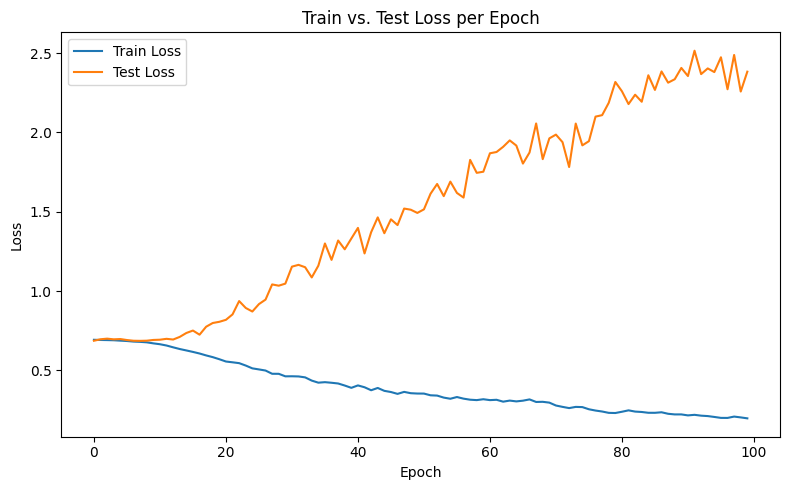

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.005 | Epochs: 100 | Batch: 64 | Security type: technical
[Epoch 5/100]  Train Loss: 0.6869
[Epoch 10/100]  Train Loss: 0.6728
[Epoch 15/100]  Train Loss: 0.6386
[Epoch 20/100]  Train Loss: 0.5828
[Epoch 25/100]  Train Loss: 0.5421
[Epoch 30/100]  Train Loss: 0.4846
[Epoch 35/100]  Train Loss: 0.4353
[Epoch 40/100]  Train Loss: 0.4199
[Epoch 45/100]  Train Loss: 0.3969
[Epoch 50/100]  Train Loss: 0.3535
[Epoch 55/100]  Train Loss: 0.3314
[Epoch 60/100]  Train Loss: 0.2981
[Epoch 65/100]  Train Loss: 0.2822
[Epoch 70/100]  Train Loss: 0.2872
[Epoch 75/100]  Train Loss: 0.2578
[Epoch 80/100]  Train Loss: 0.2472
[Epoch 85/100]  Train Loss: 0.2357
[Epoch 90/100]  Train Loss: 0.2163
[Epoch 95/100]  Train Loss: 0.2121
[Epoch 100/100]  Train Loss: 0.1953
Accuracy on Nonzero Predictions: 0.5133


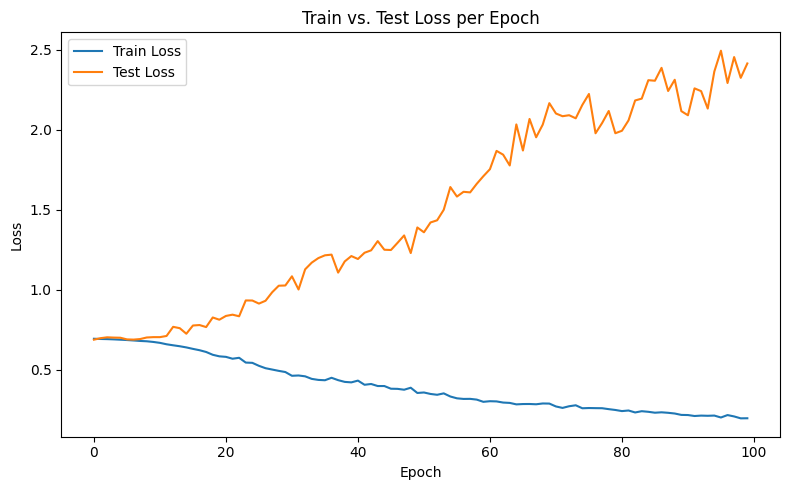

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.005 | Epochs: 100 | Batch: 64 | Security type: technical
[Epoch 5/100]  Train Loss: 0.6872
[Epoch 10/100]  Train Loss: 0.6722
[Epoch 15/100]  Train Loss: 0.6413
[Epoch 20/100]  Train Loss: 0.5932
[Epoch 25/100]  Train Loss: 0.5371
[Epoch 30/100]  Train Loss: 0.4772
[Epoch 35/100]  Train Loss: 0.4240
[Epoch 40/100]  Train Loss: 0.3949
[Epoch 45/100]  Train Loss: 0.3546
[Epoch 50/100]  Train Loss: 0.3304
[Epoch 55/100]  Train Loss: 0.3230
[Epoch 60/100]  Train Loss: 0.3167
[Epoch 65/100]  Train Loss: 0.3018
[Epoch 70/100]  Train Loss: 0.2839
[Epoch 75/100]  Train Loss: 0.2703
[Epoch 80/100]  Train Loss: 0.2528
[Epoch 85/100]  Train Loss: 0.2477
[Epoch 90/100]  Train Loss: 0.2549
[Epoch 95/100]  Train Loss: 0.2408
[Epoch 100/100]  Train Loss: 0.2198
Accuracy on Nonzero Predictions: 0.5333


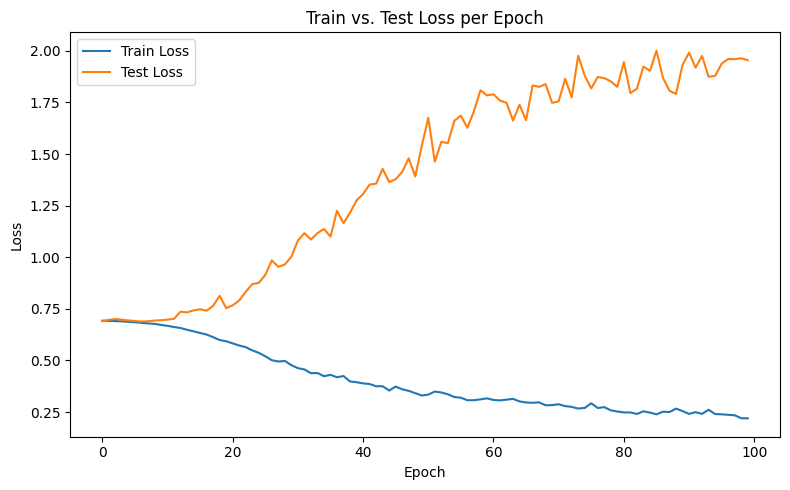

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.005 | Epochs: 100 | Batch: 64 | Security type: technical
[Epoch 5/100]  Train Loss: 0.6883
[Epoch 10/100]  Train Loss: 0.6734
[Epoch 15/100]  Train Loss: 0.6492
[Epoch 20/100]  Train Loss: 0.6052
[Epoch 25/100]  Train Loss: 0.5539
[Epoch 30/100]  Train Loss: 0.4874
[Epoch 35/100]  Train Loss: 0.4640
[Epoch 40/100]  Train Loss: 0.4226
[Epoch 45/100]  Train Loss: 0.3867
[Epoch 50/100]  Train Loss: 0.3858
[Epoch 55/100]  Train Loss: 0.3471
[Epoch 60/100]  Train Loss: 0.3267
[Epoch 65/100]  Train Loss: 0.2938
[Epoch 70/100]  Train Loss: 0.2672
[Epoch 75/100]  Train Loss: 0.2495
[Epoch 80/100]  Train Loss: 0.2640
[Epoch 85/100]  Train Loss: 0.2410
[Epoch 90/100]  Train Loss: 0.2389
[Epoch 95/100]  Train Loss: 0.2054
[Epoch 100/100]  Train Loss: 0.1987
Accuracy on Nonzero Predictions: 0.5367


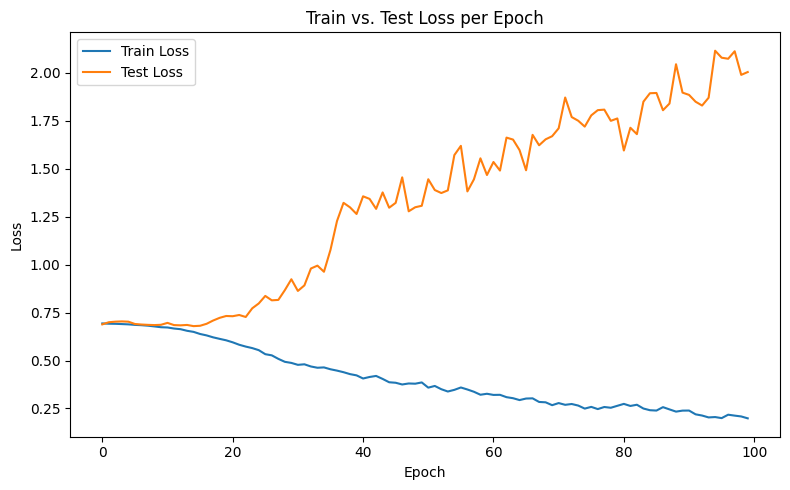

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.005 | Epochs: 100 | Batch: 64 | Security type: technical
[Epoch 5/100]  Train Loss: 0.6873
[Epoch 10/100]  Train Loss: 0.6775
[Epoch 15/100]  Train Loss: 0.6455
[Epoch 20/100]  Train Loss: 0.5946
[Epoch 25/100]  Train Loss: 0.5378
[Epoch 30/100]  Train Loss: 0.5035
[Epoch 35/100]  Train Loss: 0.4525
[Epoch 40/100]  Train Loss: 0.3976
[Epoch 45/100]  Train Loss: 0.3752
[Epoch 50/100]  Train Loss: 0.3550
[Epoch 55/100]  Train Loss: 0.3326
[Epoch 60/100]  Train Loss: 0.2941
[Epoch 65/100]  Train Loss: 0.2742
[Epoch 70/100]  Train Loss: 0.2656
[Epoch 75/100]  Train Loss: 0.2647
[Epoch 80/100]  Train Loss: 0.2397
[Epoch 85/100]  Train Loss: 0.2273
[Epoch 90/100]  Train Loss: 0.2315
[Epoch 95/100]  Train Loss: 0.2110
[Epoch 100/100]  Train Loss: 0.2134
Accuracy on Nonzero Predictions: 0.4467


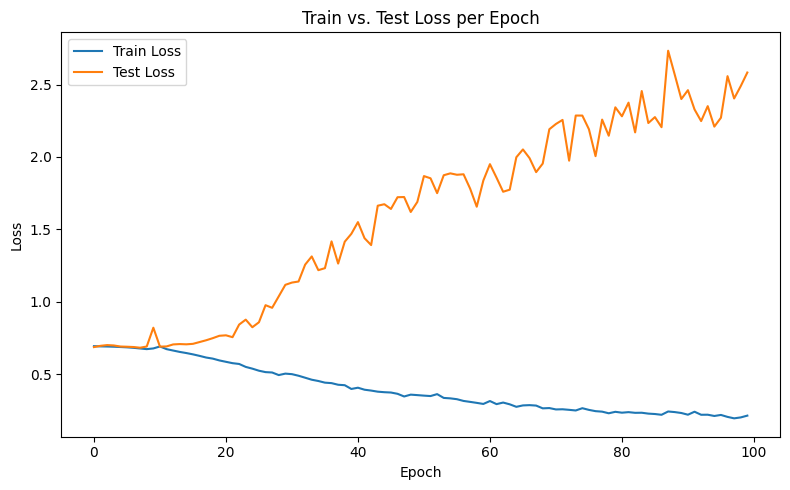

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.005 | Epochs: 100 | Batch: 64 | Security type: technical
[Epoch 5/100]  Train Loss: 0.6938
[Epoch 10/100]  Train Loss: 0.6924
[Epoch 15/100]  Train Loss: 0.7000
[Epoch 20/100]  Train Loss: 0.6970
[Epoch 25/100]  Train Loss: 0.6941
[Epoch 30/100]  Train Loss: 0.6963
[Epoch 35/100]  Train Loss: 0.6966
[Epoch 40/100]  Train Loss: 0.6985
[Epoch 45/100]  Train Loss: 0.6957
[Epoch 50/100]  Train Loss: 0.6952
[Epoch 55/100]  Train Loss: 0.6911
[Epoch 60/100]  Train Loss: 0.6926
[Epoch 65/100]  Train Loss: 0.6937
[Epoch 70/100]  Train Loss: 0.6910
[Epoch 75/100]  Train Loss: 0.6891
[Epoch 80/100]  Train Loss: 0.6862
[Epoch 85/100]  Train Loss: 0.6907
[Epoch 90/100]  Train Loss: 0.6878
[Epoch 95/100]  Train Loss: 0.6881
[Epoch 100/100]  Train Loss: 0.6839
Accuracy on Nonzero Predictions: 0.5367


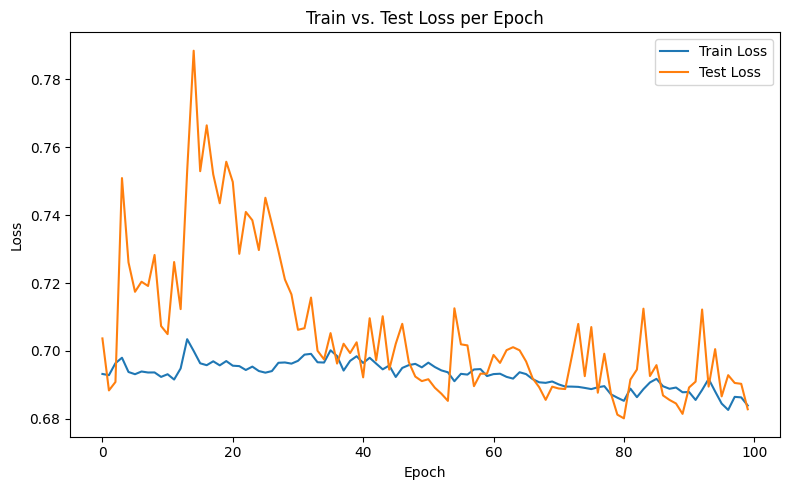

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.005 | Epochs: 100 | Batch: 64 | Security type: technical
[Epoch 5/100]  Train Loss: 0.6949
[Epoch 10/100]  Train Loss: 0.6940
[Epoch 15/100]  Train Loss: 0.6949
[Epoch 20/100]  Train Loss: 0.6942
[Epoch 25/100]  Train Loss: 0.6930
[Epoch 30/100]  Train Loss: 0.6914
[Epoch 35/100]  Train Loss: 0.6856
[Epoch 40/100]  Train Loss: 0.6790
[Epoch 45/100]  Train Loss: 0.6715
[Epoch 50/100]  Train Loss: 0.6678
[Epoch 55/100]  Train Loss: 0.6635
[Epoch 60/100]  Train Loss: 0.6538
[Epoch 65/100]  Train Loss: 0.6531
[Epoch 70/100]  Train Loss: 0.6544
[Epoch 75/100]  Train Loss: 0.6592
[Epoch 80/100]  Train Loss: 0.6646
[Epoch 85/100]  Train Loss: 0.6649
[Epoch 90/100]  Train Loss: 0.6869
[Epoch 95/100]  Train Loss: 0.6976
[Epoch 100/100]  Train Loss: 0.6981
Accuracy on Nonzero Predictions: 0.5200


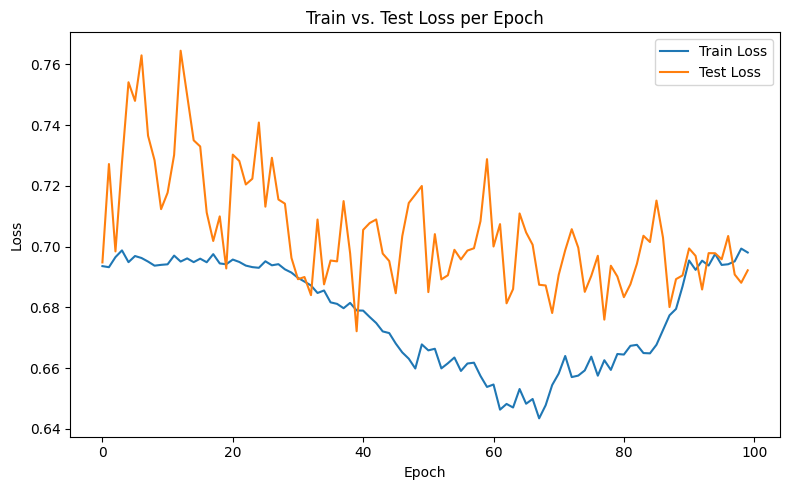

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.005 | Epochs: 100 | Batch: 64 | Security type: technical
[Epoch 5/100]  Train Loss: 0.6934
[Epoch 10/100]  Train Loss: 0.6932
[Epoch 15/100]  Train Loss: 0.6933
[Epoch 20/100]  Train Loss: 0.6931
[Epoch 25/100]  Train Loss: 0.6919
[Epoch 30/100]  Train Loss: 0.6917
[Epoch 35/100]  Train Loss: 0.6913
[Epoch 40/100]  Train Loss: 0.6915
[Epoch 45/100]  Train Loss: 0.6906
[Epoch 50/100]  Train Loss: 0.6899
[Epoch 55/100]  Train Loss: 0.6901
[Epoch 60/100]  Train Loss: 0.6905
[Epoch 65/100]  Train Loss: 0.6864
[Epoch 70/100]  Train Loss: 0.6851
[Epoch 75/100]  Train Loss: 0.6841
[Epoch 80/100]  Train Loss: 0.6821
[Epoch 85/100]  Train Loss: 0.6765
[Epoch 90/100]  Train Loss: 0.6747
[Epoch 95/100]  Train Loss: 0.6687
[Epoch 100/100]  Train Loss: 0.6653
Accuracy on Nonzero Predictions: 0.5233


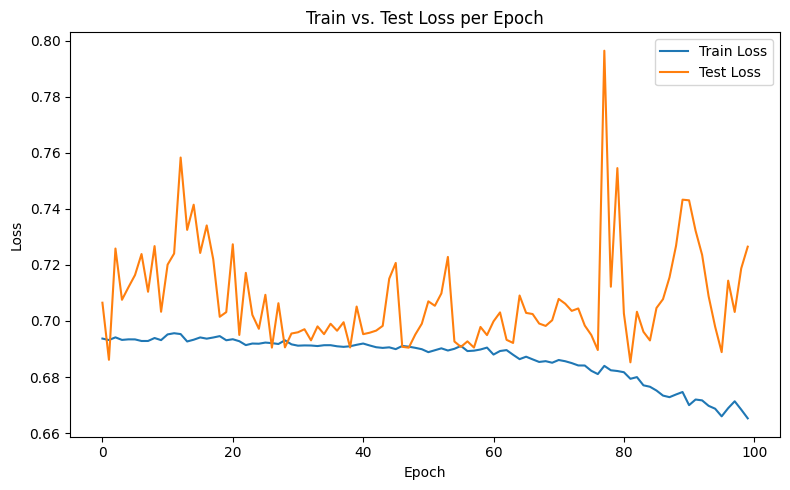

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.005 | Epochs: 100 | Batch: 64 | Security type: technical
[Epoch 5/100]  Train Loss: 0.6929
[Epoch 10/100]  Train Loss: 0.6949
[Epoch 15/100]  Train Loss: 0.6989
[Epoch 20/100]  Train Loss: 0.7157
[Epoch 25/100]  Train Loss: 0.6966
[Epoch 30/100]  Train Loss: 0.6956
[Epoch 35/100]  Train Loss: 0.6917
[Epoch 40/100]  Train Loss: 0.6905
[Epoch 45/100]  Train Loss: 0.6931
[Epoch 50/100]  Train Loss: 0.6948
[Epoch 55/100]  Train Loss: 0.6963
[Epoch 60/100]  Train Loss: 0.7003
[Epoch 65/100]  Train Loss: 0.6956
[Epoch 70/100]  Train Loss: 0.6964
[Epoch 75/100]  Train Loss: 0.6929
[Epoch 80/100]  Train Loss: 0.6914
[Epoch 85/100]  Train Loss: 0.6892
[Epoch 90/100]  Train Loss: 0.6906
[Epoch 95/100]  Train Loss: 0.6905
[Epoch 100/100]  Train Loss: 0.6924
Accuracy on Nonzero Predictions: 0.4700


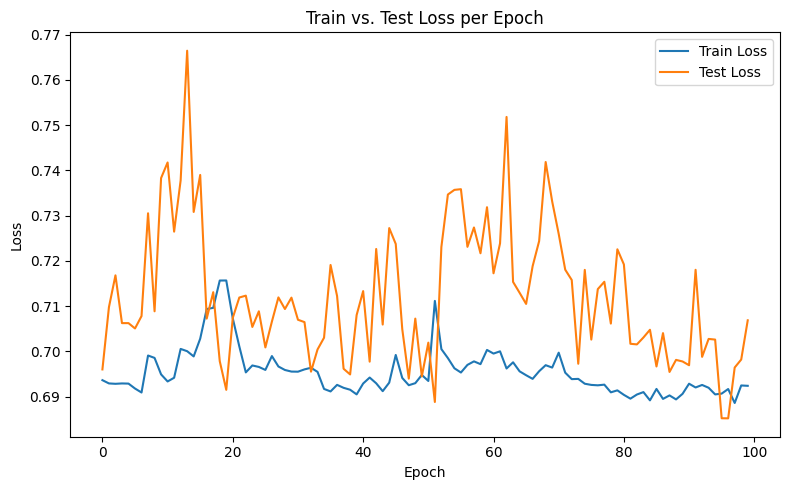

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.005 | Epochs: 100 | Batch: 64 | Security type: technical
[Epoch 5/100]  Train Loss: 0.6977
[Epoch 10/100]  Train Loss: 0.6962
[Epoch 15/100]  Train Loss: 0.6946
[Epoch 20/100]  Train Loss: 0.6974
[Epoch 25/100]  Train Loss: 0.6944
[Epoch 30/100]  Train Loss: 0.6928
[Epoch 35/100]  Train Loss: 0.6909
[Epoch 40/100]  Train Loss: 0.6901
[Epoch 45/100]  Train Loss: 0.6907
[Epoch 50/100]  Train Loss: 0.6874
[Epoch 55/100]  Train Loss: 0.6861
[Epoch 60/100]  Train Loss: 0.6825
[Epoch 65/100]  Train Loss: 0.6779
[Epoch 70/100]  Train Loss: 0.6744
[Epoch 75/100]  Train Loss: 0.6699
[Epoch 80/100]  Train Loss: 0.6603
[Epoch 85/100]  Train Loss: 0.6564
[Epoch 90/100]  Train Loss: 0.6500
[Epoch 95/100]  Train Loss: 0.6459
[Epoch 100/100]  Train Loss: 0.6414
Accuracy on Nonzero Predictions: 0.4867


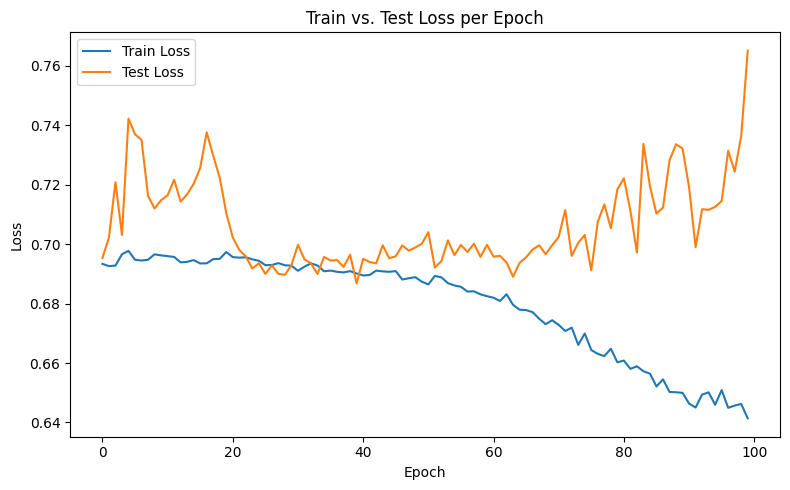

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
----- Appending stock: AAPL, period: 10y, data_type: technical -----
----- Appending stock: MSFT, period: 10y, data_type: technical -----
----- Appending stock: AMZN, period: 10y, data_type: technical -----
----- Appending stock: NVDA, period: 10y, data_type: technical -----
----- Appending stock: SPX, period: 10y, data_type: technical -----
Final X shape: (11340, 92, 10)
Final y shape: (11340,)
Training SPX | LR: 0.005 | Epochs: 100 | Batch: 64 | Security type: technical
[Epoch 5/100]  Train Loss: 0.6789
[Epoch 10/100]  Train Loss: 0.6108
[Epoch 15/100]  Train Loss: 0.5077
[Epoch 20/100]  Train Loss: 0.4165
[Epoch 25/100]  Train Loss: 0.3325
[Epoch 30/100]  Train Loss: 0.2773
[Epoch 35/100]  Train Loss: 0.2273
[Epoch 40/100]  Train Loss: 0.1893
[Epoch 45/100]  Train Loss: 0.1638
[Epoch 50/100]  Train Loss: 0.1471
[Epoch 55/100]  Train Loss: 0.1363
[Epoch 60/100]  Train Loss: 0.132

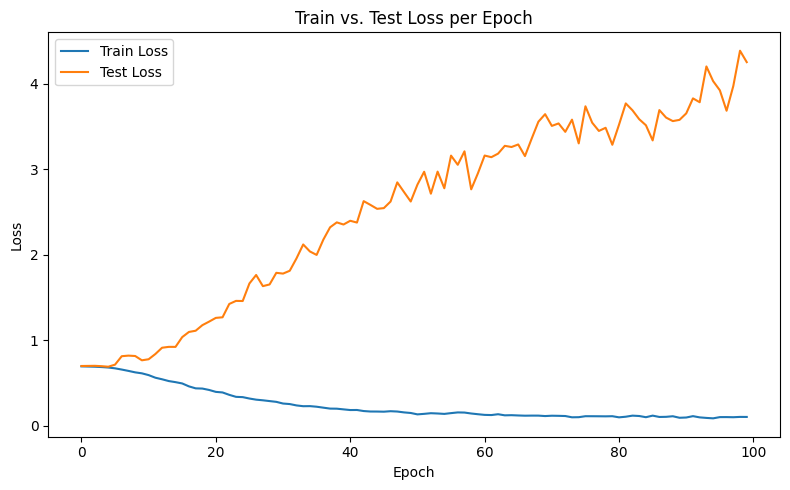

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.005 | Epochs: 100 | Batch: 64 | Security type: technical
[Epoch 5/100]  Train Loss: 0.6800
[Epoch 10/100]  Train Loss: 0.6131
[Epoch 15/100]  Train Loss: 0.4963
[Epoch 20/100]  Train Loss: 0.4097
[Epoch 25/100]  Train Loss: 0.3204
[Epoch 30/100]  Train Loss: 0.2590
[Epoch 35/100]  Train Loss: 0.2164
[Epoch 40/100]  Train Loss: 0.1899
[Epoch 45/100]  Train Loss: 0.1506
[Epoch 50/100]  Train Loss: 0.1354
[Epoch 55/100]  Train Loss: 0.1294
[Epoch 60/100]  Train Loss: 0.1225
[Epoch 65/100]  Train Loss: 0.1204
[Epoch 70/100]  Train Loss: 0.1156
[Epoch 75/100]  Train Loss: 0.0970
[Epoch 80/100]  Train Loss: 0.0804
[Epoch 85/100]  Train Loss: 0.0820
[Epoch 90/100]  Train Loss: 0.0722
[Epoch 95/100]  Train Loss: 0.0993
[Epoch 100/100]  Train Loss: 0.0830
Accuracy on Nonzero Predictions: 0.4500


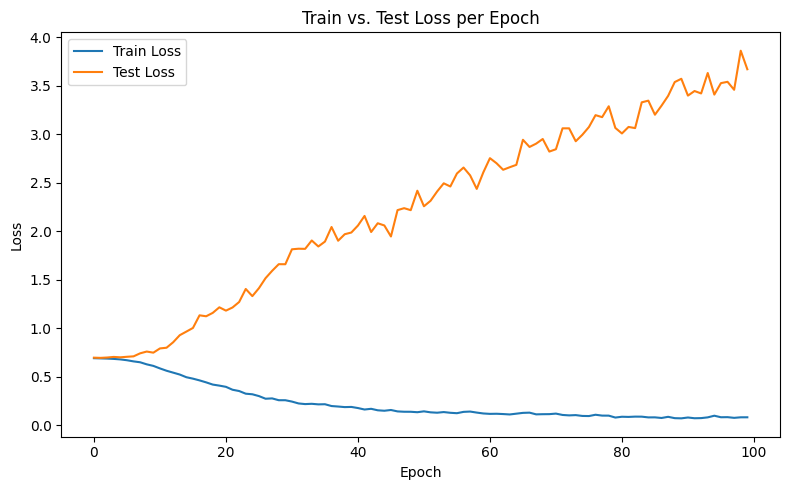

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.005 | Epochs: 100 | Batch: 64 | Security type: technical
[Epoch 5/100]  Train Loss: 0.6797
[Epoch 10/100]  Train Loss: 0.6125
[Epoch 15/100]  Train Loss: 0.4926
[Epoch 20/100]  Train Loss: 0.4040
[Epoch 25/100]  Train Loss: 0.3296
[Epoch 30/100]  Train Loss: 0.2638
[Epoch 35/100]  Train Loss: 0.2313
[Epoch 40/100]  Train Loss: 0.2044
[Epoch 45/100]  Train Loss: 0.1731
[Epoch 50/100]  Train Loss: 0.1556
[Epoch 55/100]  Train Loss: 0.1477
[Epoch 60/100]  Train Loss: 0.1332
[Epoch 65/100]  Train Loss: 0.1183
[Epoch 70/100]  Train Loss: 0.1232
[Epoch 75/100]  Train Loss: 0.1041
[Epoch 80/100]  Train Loss: 0.0985
[Epoch 85/100]  Train Loss: 0.0952
[Epoch 90/100]  Train Loss: 0.1009
[Epoch 95/100]  Train Loss: 0.0785
[Epoch 100/100]  Train Loss: 0.0838
Accuracy on Nonzero Predictions: 0.4333


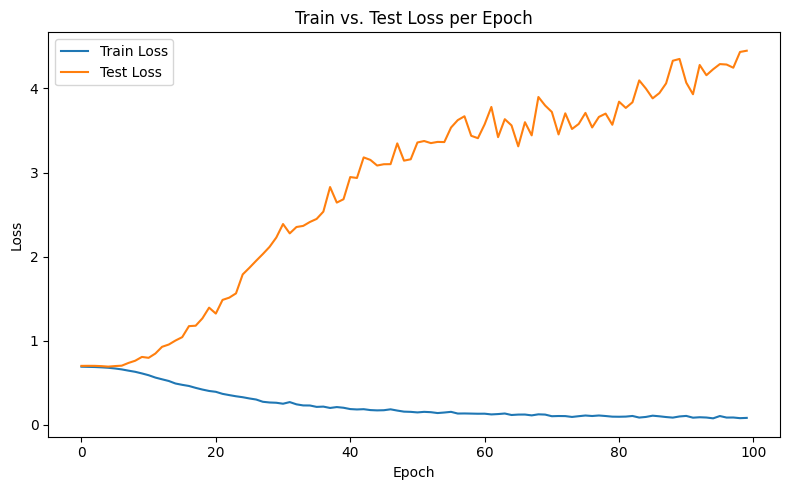

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.005 | Epochs: 100 | Batch: 64 | Security type: technical
[Epoch 5/100]  Train Loss: 0.6797
[Epoch 10/100]  Train Loss: 0.6027
[Epoch 15/100]  Train Loss: 0.5162
[Epoch 20/100]  Train Loss: 0.4154
[Epoch 25/100]  Train Loss: 0.3385
[Epoch 30/100]  Train Loss: 0.2844
[Epoch 35/100]  Train Loss: 0.2504
[Epoch 40/100]  Train Loss: 0.2151
[Epoch 45/100]  Train Loss: 0.1842
[Epoch 50/100]  Train Loss: 0.1605
[Epoch 55/100]  Train Loss: 0.1561
[Epoch 60/100]  Train Loss: 0.1522
[Epoch 65/100]  Train Loss: 0.1361
[Epoch 70/100]  Train Loss: 0.1219
[Epoch 75/100]  Train Loss: 0.1239
[Epoch 80/100]  Train Loss: 0.1177
[Epoch 85/100]  Train Loss: 0.1144
[Epoch 90/100]  Train Loss: 0.0976
[Epoch 95/100]  Train Loss: 0.0922
[Epoch 100/100]  Train Loss: 0.0823
Accuracy on Nonzero Predictions: 0.4833


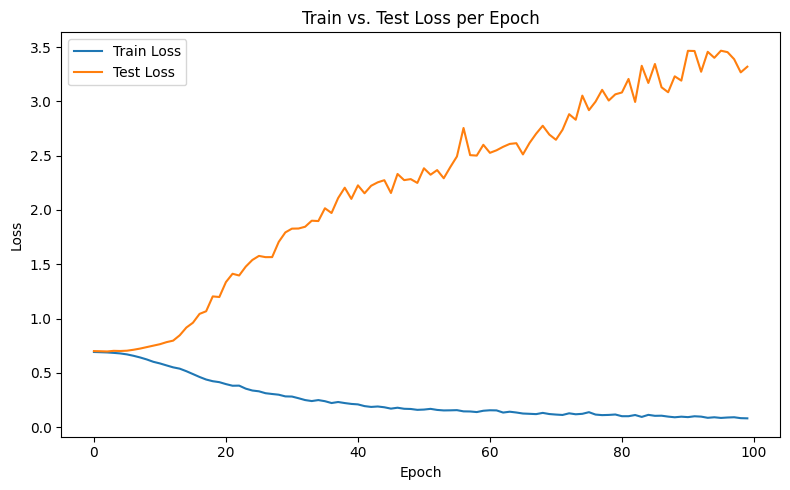

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.005 | Epochs: 100 | Batch: 64 | Security type: technical
[Epoch 5/100]  Train Loss: 0.6779
[Epoch 10/100]  Train Loss: 0.6033
[Epoch 15/100]  Train Loss: 0.4949
[Epoch 20/100]  Train Loss: 0.4102
[Epoch 25/100]  Train Loss: 0.3434
[Epoch 30/100]  Train Loss: 0.2809
[Epoch 35/100]  Train Loss: 0.2317
[Epoch 40/100]  Train Loss: 0.1990
[Epoch 45/100]  Train Loss: 0.1649
[Epoch 50/100]  Train Loss: 0.1483
[Epoch 55/100]  Train Loss: 0.1502
[Epoch 60/100]  Train Loss: 0.1147
[Epoch 65/100]  Train Loss: 0.1217
[Epoch 70/100]  Train Loss: 0.1116
[Epoch 75/100]  Train Loss: 0.0997
[Epoch 80/100]  Train Loss: 0.0935
[Epoch 85/100]  Train Loss: 0.0999
[Epoch 90/100]  Train Loss: 0.0775
[Epoch 95/100]  Train Loss: 0.0911
[Epoch 100/100]  Train Loss: 0.0903
Accuracy on Nonzero Predictions: 0.5467


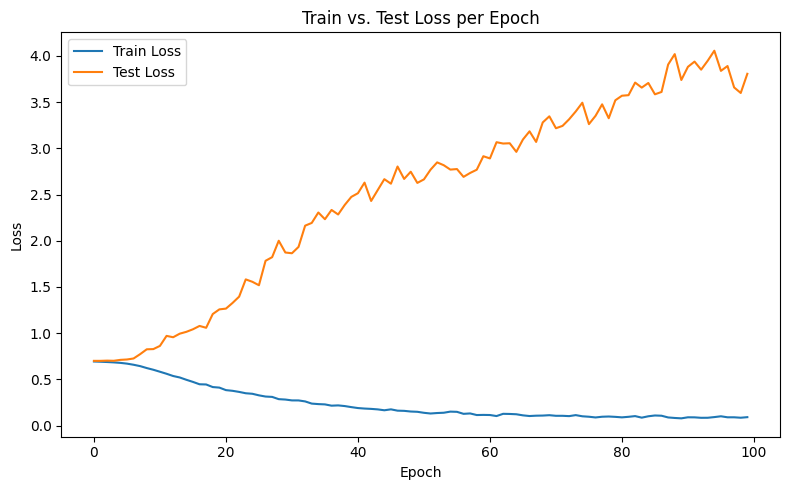

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.005 | Epochs: 100 | Batch: 64 | Security type: technical
[Epoch 5/100]  Train Loss: 0.6921
[Epoch 10/100]  Train Loss: 0.6857
[Epoch 15/100]  Train Loss: 0.6796
[Epoch 20/100]  Train Loss: 0.6936
[Epoch 25/100]  Train Loss: 0.6984
[Epoch 30/100]  Train Loss: 0.6994
[Epoch 35/100]  Train Loss: 0.6978
[Epoch 40/100]  Train Loss: 0.7086
[Epoch 45/100]  Train Loss: 0.6963
[Epoch 50/100]  Train Loss: 0.7013
[Epoch 55/100]  Train Loss: 0.6961
[Epoch 60/100]  Train Loss: 0.6987
[Epoch 65/100]  Train Loss: 0.6985
[Epoch 70/100]  Train Loss: 0.6995
[Epoch 75/100]  Train Loss: 0.6970
[Epoch 80/100]  Train Loss: 0.7007
[Epoch 85/100]  Train Loss: 0.6963
[Epoch 90/100]  Train Loss: 0.6947
[Epoch 95/100]  Train Loss: 0.6934
[Epoch 100/100]  Train Loss: 0.6936
Accuracy on Nonzero Predictions: 0.4367


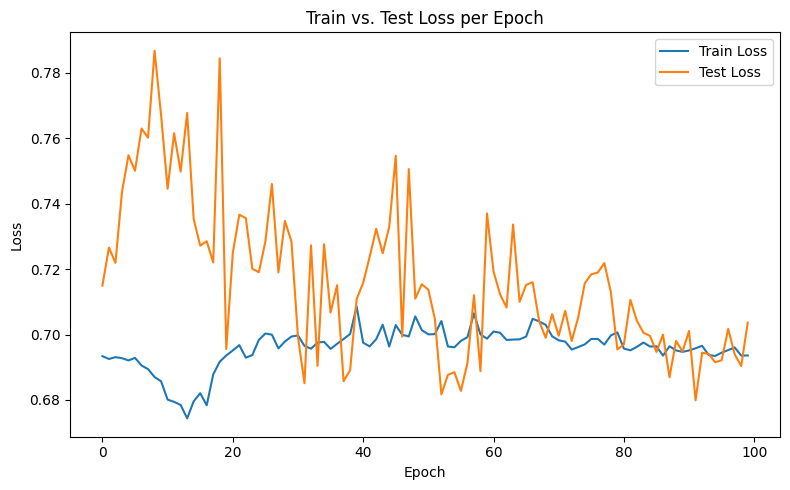

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.005 | Epochs: 100 | Batch: 64 | Security type: technical
[Epoch 5/100]  Train Loss: 0.6950
[Epoch 10/100]  Train Loss: 0.6931
[Epoch 15/100]  Train Loss: 0.6908
[Epoch 20/100]  Train Loss: 0.6841
[Epoch 25/100]  Train Loss: 0.6769
[Epoch 30/100]  Train Loss: 0.6708
[Epoch 35/100]  Train Loss: 0.6565
[Epoch 40/100]  Train Loss: 0.6500
[Epoch 45/100]  Train Loss: 0.6437
[Epoch 50/100]  Train Loss: 0.6589
[Epoch 55/100]  Train Loss: 0.6518
[Epoch 60/100]  Train Loss: 0.6431
[Epoch 65/100]  Train Loss: 0.6497
[Epoch 70/100]  Train Loss: 0.6644
[Epoch 75/100]  Train Loss: 0.6483
[Epoch 80/100]  Train Loss: 0.6572
[Epoch 85/100]  Train Loss: 0.6556
[Epoch 90/100]  Train Loss: 0.6675
[Epoch 95/100]  Train Loss: 0.6807
[Epoch 100/100]  Train Loss: 0.6800
Accuracy on Nonzero Predictions: 0.5733


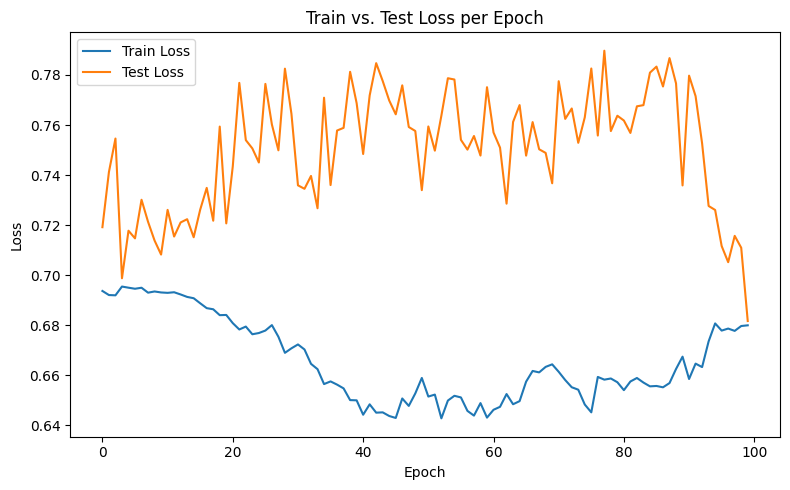

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.005 | Epochs: 100 | Batch: 64 | Security type: technical
[Epoch 5/100]  Train Loss: 0.6960
[Epoch 10/100]  Train Loss: 0.6918
[Epoch 15/100]  Train Loss: 0.6912
[Epoch 20/100]  Train Loss: 0.6961
[Epoch 25/100]  Train Loss: 0.6920
[Epoch 30/100]  Train Loss: 0.6885
[Epoch 35/100]  Train Loss: 0.6797
[Epoch 40/100]  Train Loss: 0.6840
[Epoch 45/100]  Train Loss: 0.6837
[Epoch 50/100]  Train Loss: 0.6817
[Epoch 55/100]  Train Loss: 0.6818
[Epoch 60/100]  Train Loss: 0.6749
[Epoch 65/100]  Train Loss: 0.6785
[Epoch 70/100]  Train Loss: 0.6719
[Epoch 75/100]  Train Loss: 0.6627
[Epoch 80/100]  Train Loss: 0.6651
[Epoch 85/100]  Train Loss: 0.6600
[Epoch 90/100]  Train Loss: 0.6785
[Epoch 95/100]  Train Loss: 0.6738
[Epoch 100/100]  Train Loss: 0.6789
Accuracy on Nonzero Predictions: 0.4533


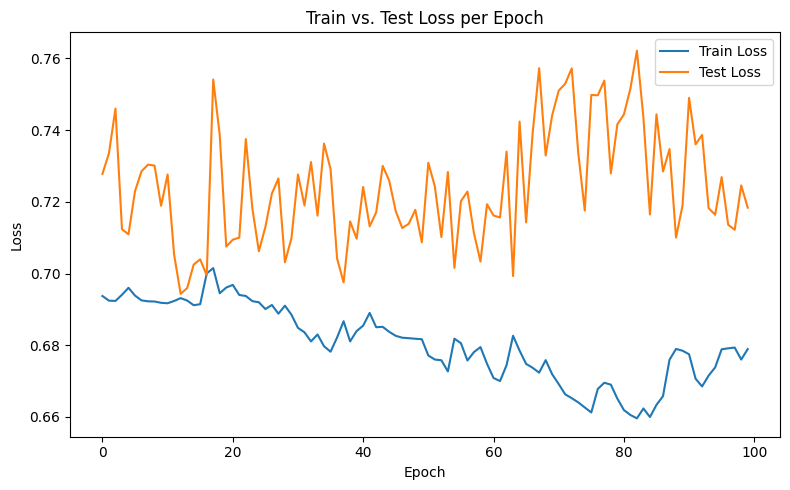

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.005 | Epochs: 100 | Batch: 64 | Security type: technical
[Epoch 5/100]  Train Loss: 0.6932
[Epoch 10/100]  Train Loss: 0.6937
[Epoch 15/100]  Train Loss: 0.6900
[Epoch 20/100]  Train Loss: 0.6914
[Epoch 25/100]  Train Loss: 0.6880
[Epoch 30/100]  Train Loss: 0.6850
[Epoch 35/100]  Train Loss: 0.6877
[Epoch 40/100]  Train Loss: 0.6864
[Epoch 45/100]  Train Loss: 0.6840
[Epoch 50/100]  Train Loss: 0.6871
[Epoch 55/100]  Train Loss: 0.6862
[Epoch 60/100]  Train Loss: 0.6796
[Epoch 65/100]  Train Loss: 0.7073
[Epoch 70/100]  Train Loss: 0.6961
[Epoch 75/100]  Train Loss: 0.7034
[Epoch 80/100]  Train Loss: 0.6976
[Epoch 85/100]  Train Loss: 0.7183
[Epoch 90/100]  Train Loss: 0.6989
[Epoch 95/100]  Train Loss: 0.6986
[Epoch 100/100]  Train Loss: 0.6928
Accuracy on Nonzero Predictions: 0.4833


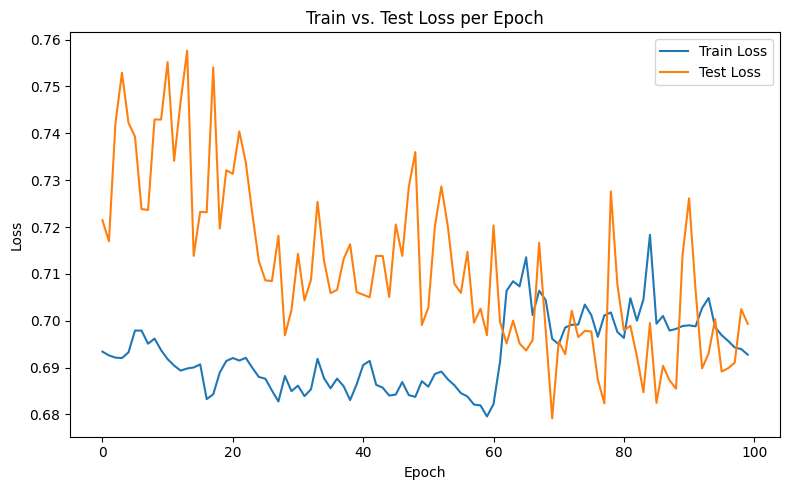

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.005 | Epochs: 100 | Batch: 64 | Security type: technical
[Epoch 5/100]  Train Loss: 0.6936
[Epoch 10/100]  Train Loss: 0.6860
[Epoch 15/100]  Train Loss: 0.6786
[Epoch 20/100]  Train Loss: 0.6784
[Epoch 25/100]  Train Loss: 0.6975
[Epoch 30/100]  Train Loss: 0.6969
[Epoch 35/100]  Train Loss: 0.6975
[Epoch 40/100]  Train Loss: 0.6998
[Epoch 45/100]  Train Loss: 0.6969
[Epoch 50/100]  Train Loss: 0.7197
[Epoch 55/100]  Train Loss: 0.7111
[Epoch 60/100]  Train Loss: 0.6988
[Epoch 65/100]  Train Loss: 0.6959
[Epoch 70/100]  Train Loss: 0.6981
[Epoch 75/100]  Train Loss: 0.6932
[Epoch 80/100]  Train Loss: 0.6938
[Epoch 85/100]  Train Loss: 0.6935
[Epoch 90/100]  Train Loss: 0.6927
[Epoch 95/100]  Train Loss: 0.6922
[Epoch 100/100]  Train Loss: 0.6922
Accuracy on Nonzero Predictions: 0.5133


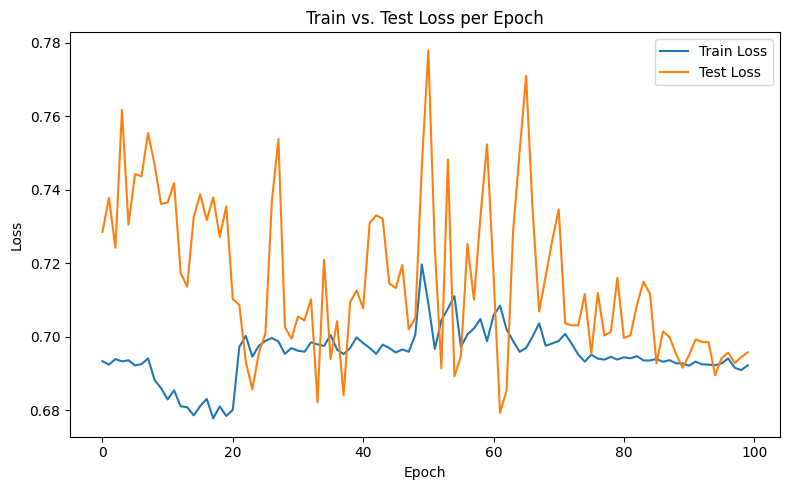

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
----- Appending stock: AAPL, period: 10y, data_type: technical -----
----- Appending stock: MSFT, period: 10y, data_type: technical -----
----- Appending stock: AMZN, period: 10y, data_type: technical -----
----- Appending stock: NVDA, period: 10y, data_type: technical -----
----- Appending stock: SPX, period: 10y, data_type: technical -----
Final X shape: (11140, 92, 50)
Final y shape: (11140,)
Training SPX | LR: 0.005 | Epochs: 100 | Batch: 64 | Security type: technical
[Epoch 5/100]  Train Loss: 0.4557
[Epoch 10/100]  Train Loss: 0.1281
[Epoch 15/100]  Train Loss: 0.0502
[Epoch 20/100]  Train Loss: 0.0114
[Epoch 25/100]  Train Loss: 0.0011
[Epoch 30/100]  Train Loss: 0.0005
[Epoch 35/100]  Train Loss: 0.0003
[Epoch 40/100]  Train Loss: 0.0002
[Epoch 45/100]  Train Loss: 0.0001
[Epoch 50/100]  Train Loss: 0.0001
[Epoch 55/100]  Train Loss: 0.0000
[Epoch 60/100]  Train Loss: 0.000

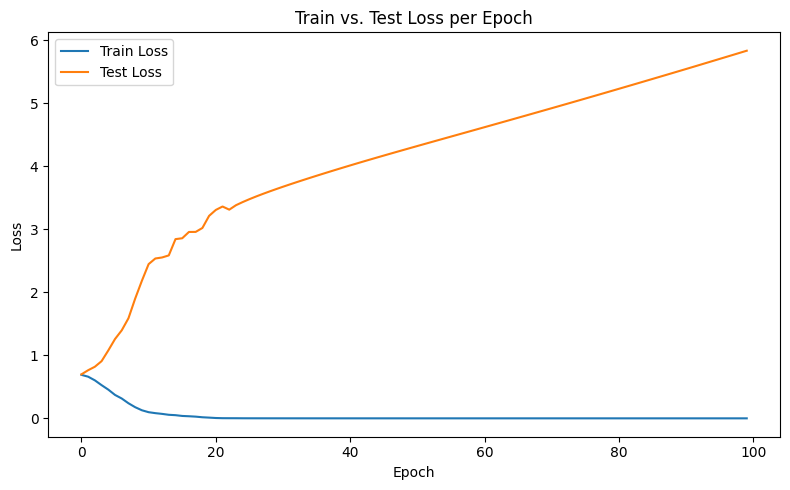

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.005 | Epochs: 100 | Batch: 64 | Security type: technical
[Epoch 5/100]  Train Loss: 0.4484
[Epoch 10/100]  Train Loss: 0.1416
[Epoch 15/100]  Train Loss: 0.0471
[Epoch 20/100]  Train Loss: 0.0224
[Epoch 25/100]  Train Loss: 0.0447
[Epoch 30/100]  Train Loss: 0.0014
[Epoch 35/100]  Train Loss: 0.0006
[Epoch 40/100]  Train Loss: 0.0003
[Epoch 45/100]  Train Loss: 0.0002
[Epoch 50/100]  Train Loss: 0.0001
[Epoch 55/100]  Train Loss: 0.0001
[Epoch 60/100]  Train Loss: 0.0000
[Epoch 65/100]  Train Loss: 0.0000
[Epoch 70/100]  Train Loss: 0.0000
[Epoch 75/100]  Train Loss: 0.0000
[Epoch 80/100]  Train Loss: 0.0000
[Epoch 85/100]  Train Loss: 0.0000
[Epoch 90/100]  Train Loss: 0.0000
[Epoch 95/100]  Train Loss: 0.0000
[Epoch 100/100]  Train Loss: 0.0000
Accuracy on Nonzero Predictions: 0.4933


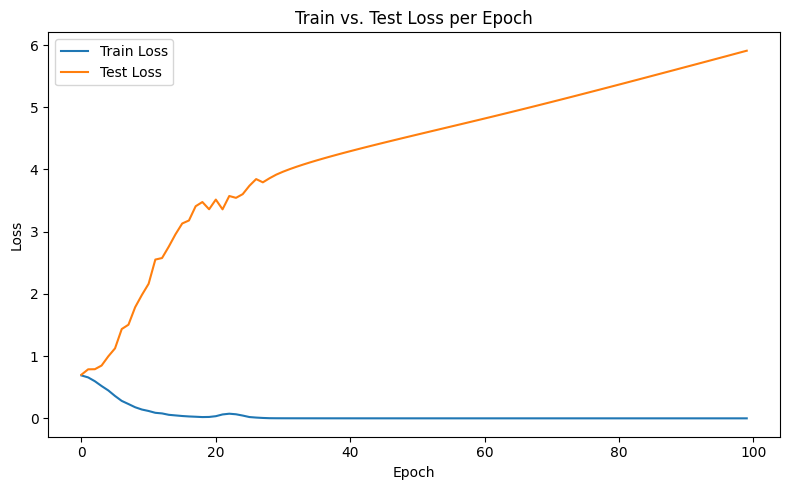

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.005 | Epochs: 100 | Batch: 64 | Security type: technical
[Epoch 5/100]  Train Loss: 0.4531
[Epoch 10/100]  Train Loss: 0.1388
[Epoch 15/100]  Train Loss: 0.0447
[Epoch 20/100]  Train Loss: 0.0047
[Epoch 25/100]  Train Loss: 0.0009
[Epoch 30/100]  Train Loss: 0.0005
[Epoch 35/100]  Train Loss: 0.0003
[Epoch 40/100]  Train Loss: 0.0002
[Epoch 45/100]  Train Loss: 0.0001
[Epoch 50/100]  Train Loss: 0.0001
[Epoch 55/100]  Train Loss: 0.0000
[Epoch 60/100]  Train Loss: 0.0000
[Epoch 65/100]  Train Loss: 0.0000
[Epoch 70/100]  Train Loss: 0.0000
[Epoch 75/100]  Train Loss: 0.0000
[Epoch 80/100]  Train Loss: 0.0000
[Epoch 85/100]  Train Loss: 0.0000
[Epoch 90/100]  Train Loss: 0.0000
[Epoch 95/100]  Train Loss: 0.0000
[Epoch 100/100]  Train Loss: 0.0000
Accuracy on Nonzero Predictions: 0.4367


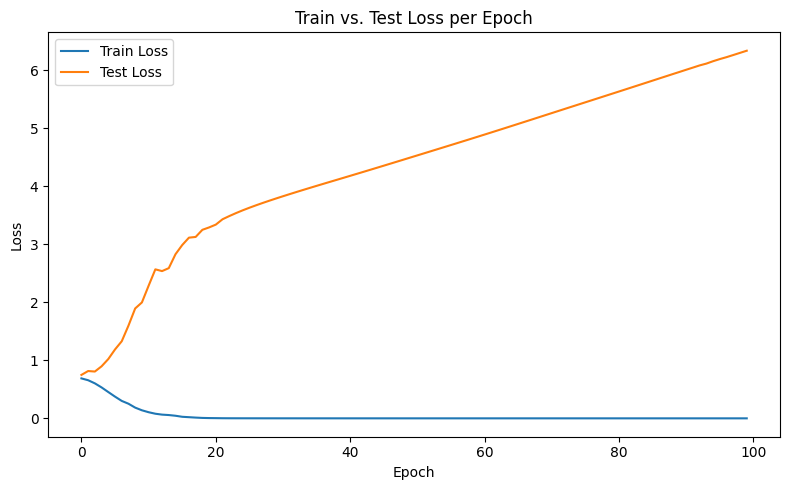

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.005 | Epochs: 100 | Batch: 64 | Security type: technical
[Epoch 5/100]  Train Loss: 0.4405
[Epoch 10/100]  Train Loss: 0.1481
[Epoch 15/100]  Train Loss: 0.0543
[Epoch 20/100]  Train Loss: 0.0414
[Epoch 25/100]  Train Loss: 0.0157
[Epoch 30/100]  Train Loss: 0.0009
[Epoch 35/100]  Train Loss: 0.0004
[Epoch 40/100]  Train Loss: 0.0002
[Epoch 45/100]  Train Loss: 0.0001
[Epoch 50/100]  Train Loss: 0.0001
[Epoch 55/100]  Train Loss: 0.0001
[Epoch 60/100]  Train Loss: 0.0000
[Epoch 65/100]  Train Loss: 0.0000
[Epoch 70/100]  Train Loss: 0.0000
[Epoch 75/100]  Train Loss: 0.0000
[Epoch 80/100]  Train Loss: 0.0000
[Epoch 85/100]  Train Loss: 0.0000
[Epoch 90/100]  Train Loss: 0.0000
[Epoch 95/100]  Train Loss: 0.0000
[Epoch 100/100]  Train Loss: 0.0000
Accuracy on Nonzero Predictions: 0.4867


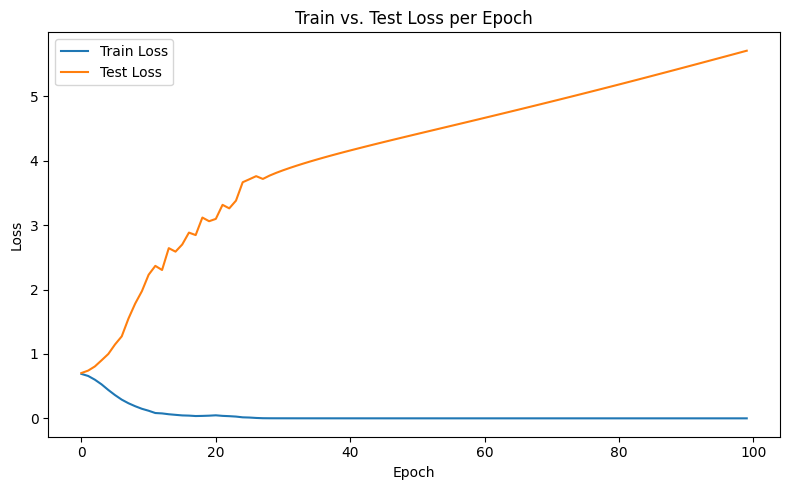

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.005 | Epochs: 100 | Batch: 64 | Security type: technical
[Epoch 5/100]  Train Loss: 0.4537
[Epoch 10/100]  Train Loss: 0.1206
[Epoch 15/100]  Train Loss: 0.0436
[Epoch 20/100]  Train Loss: 0.0033
[Epoch 25/100]  Train Loss: 0.0009
[Epoch 30/100]  Train Loss: 0.0004
[Epoch 35/100]  Train Loss: 0.0003
[Epoch 40/100]  Train Loss: 0.0001
[Epoch 45/100]  Train Loss: 0.0001
[Epoch 50/100]  Train Loss: 0.0001
[Epoch 55/100]  Train Loss: 0.0000
[Epoch 60/100]  Train Loss: 0.0000
[Epoch 65/100]  Train Loss: 0.0000
[Epoch 70/100]  Train Loss: 0.0000
[Epoch 75/100]  Train Loss: 0.0000
[Epoch 80/100]  Train Loss: 0.0000
[Epoch 85/100]  Train Loss: 0.0000
[Epoch 90/100]  Train Loss: 0.0000
[Epoch 95/100]  Train Loss: 0.0000
[Epoch 100/100]  Train Loss: 0.0000
Accuracy on Nonzero Predictions: 0.4967


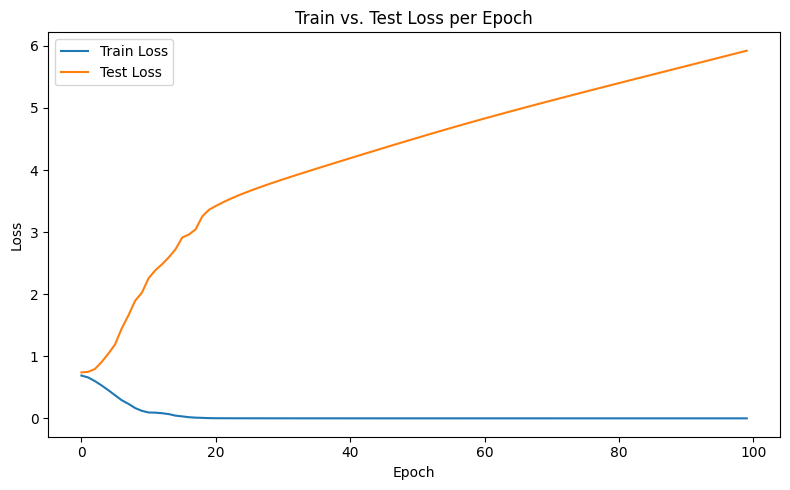

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.005 | Epochs: 100 | Batch: 64 | Security type: technical
[Epoch 5/100]  Train Loss: 0.6569
[Epoch 10/100]  Train Loss: 0.5294
[Epoch 15/100]  Train Loss: 0.4241
[Epoch 20/100]  Train Loss: 0.3856
[Epoch 25/100]  Train Loss: 0.3645
[Epoch 30/100]  Train Loss: 0.3966
[Epoch 35/100]  Train Loss: 0.4122
[Epoch 40/100]  Train Loss: 0.4449
[Epoch 45/100]  Train Loss: 0.4716
[Epoch 50/100]  Train Loss: 0.5367
[Epoch 55/100]  Train Loss: 0.5766
[Epoch 60/100]  Train Loss: 0.5930
[Epoch 65/100]  Train Loss: 0.6146
[Epoch 70/100]  Train Loss: 0.6393
[Epoch 75/100]  Train Loss: 0.6603
[Epoch 80/100]  Train Loss: 0.6811
[Epoch 85/100]  Train Loss: 0.6793
[Epoch 90/100]  Train Loss: 0.6849
[Epoch 95/100]  Train Loss: 0.6810
[Epoch 100/100]  Train Loss: 0.6847
Accuracy on Nonzero Predictions: 0.4900


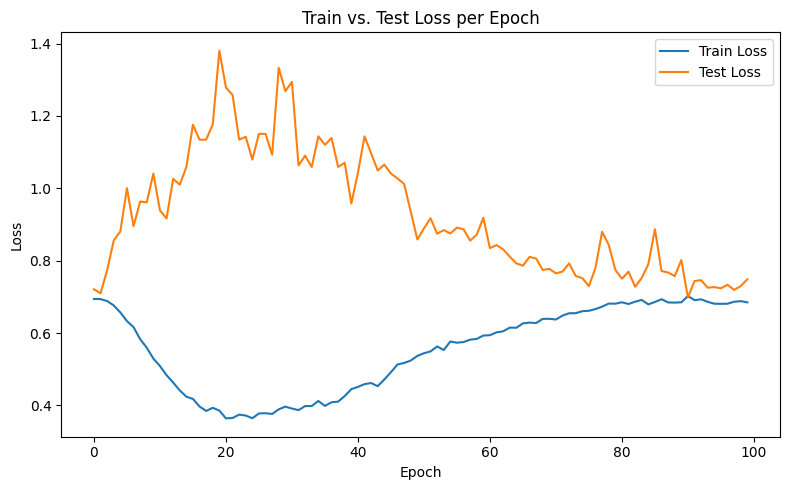

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.005 | Epochs: 100 | Batch: 64 | Security type: technical
[Epoch 5/100]  Train Loss: 0.6472
[Epoch 10/100]  Train Loss: 0.5562
[Epoch 15/100]  Train Loss: 0.4816
[Epoch 20/100]  Train Loss: 0.4409
[Epoch 25/100]  Train Loss: 0.4222
[Epoch 30/100]  Train Loss: 0.4337
[Epoch 35/100]  Train Loss: 0.4729
[Epoch 40/100]  Train Loss: 0.5341
[Epoch 45/100]  Train Loss: 0.5683
[Epoch 50/100]  Train Loss: 0.5936
[Epoch 55/100]  Train Loss: 0.6290
[Epoch 60/100]  Train Loss: 0.6522
[Epoch 65/100]  Train Loss: 0.6729
[Epoch 70/100]  Train Loss: 0.6603
[Epoch 75/100]  Train Loss: 0.6685
[Epoch 80/100]  Train Loss: 0.6866
[Epoch 85/100]  Train Loss: 0.6838
[Epoch 90/100]  Train Loss: 0.6895
[Epoch 95/100]  Train Loss: 0.7071
[Epoch 100/100]  Train Loss: 0.6953
Accuracy on Nonzero Predictions: 0.5333


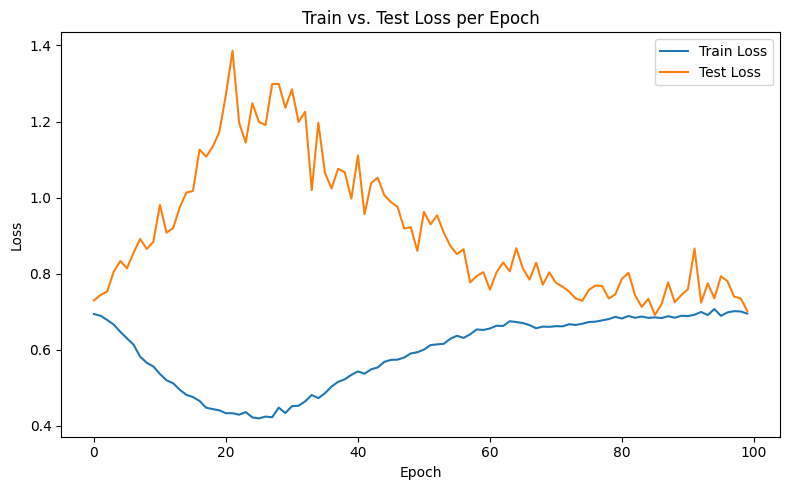

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.005 | Epochs: 100 | Batch: 64 | Security type: technical
[Epoch 5/100]  Train Loss: 0.6673
[Epoch 10/100]  Train Loss: 0.5199
[Epoch 15/100]  Train Loss: 0.3960
[Epoch 20/100]  Train Loss: 0.3284
[Epoch 25/100]  Train Loss: 0.3184
[Epoch 30/100]  Train Loss: 0.3435
[Epoch 35/100]  Train Loss: 0.3383
[Epoch 40/100]  Train Loss: 0.3603
[Epoch 45/100]  Train Loss: 0.4068
[Epoch 50/100]  Train Loss: 0.4236
[Epoch 55/100]  Train Loss: 0.4760
[Epoch 60/100]  Train Loss: 0.5260
[Epoch 65/100]  Train Loss: 0.6010
[Epoch 70/100]  Train Loss: 0.6396
[Epoch 75/100]  Train Loss: 0.6435
[Epoch 80/100]  Train Loss: 0.6632
[Epoch 85/100]  Train Loss: 0.6667
[Epoch 90/100]  Train Loss: 0.6787
[Epoch 95/100]  Train Loss: 0.6836
[Epoch 100/100]  Train Loss: 0.6946
Accuracy on Nonzero Predictions: 0.4900


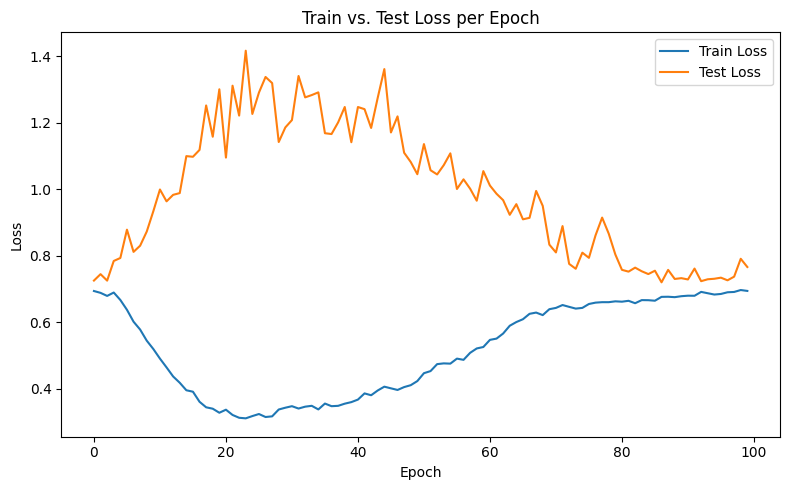

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.005 | Epochs: 100 | Batch: 64 | Security type: technical
[Epoch 5/100]  Train Loss: 0.6888
[Epoch 10/100]  Train Loss: 0.5978
[Epoch 15/100]  Train Loss: 0.4572
[Epoch 20/100]  Train Loss: 0.3640
[Epoch 25/100]  Train Loss: 0.3333
[Epoch 30/100]  Train Loss: 0.3135
[Epoch 35/100]  Train Loss: 0.3186
[Epoch 40/100]  Train Loss: 0.3497
[Epoch 45/100]  Train Loss: 0.3905
[Epoch 50/100]  Train Loss: 0.4185
[Epoch 55/100]  Train Loss: 0.4675
[Epoch 60/100]  Train Loss: 0.5071
[Epoch 65/100]  Train Loss: 0.5616
[Epoch 70/100]  Train Loss: 0.6026
[Epoch 75/100]  Train Loss: 0.6528
[Epoch 80/100]  Train Loss: 0.6578
[Epoch 85/100]  Train Loss: 0.6646
[Epoch 90/100]  Train Loss: 0.6629
[Epoch 95/100]  Train Loss: 0.6713
[Epoch 100/100]  Train Loss: 0.6707
Accuracy on Nonzero Predictions: 0.4800


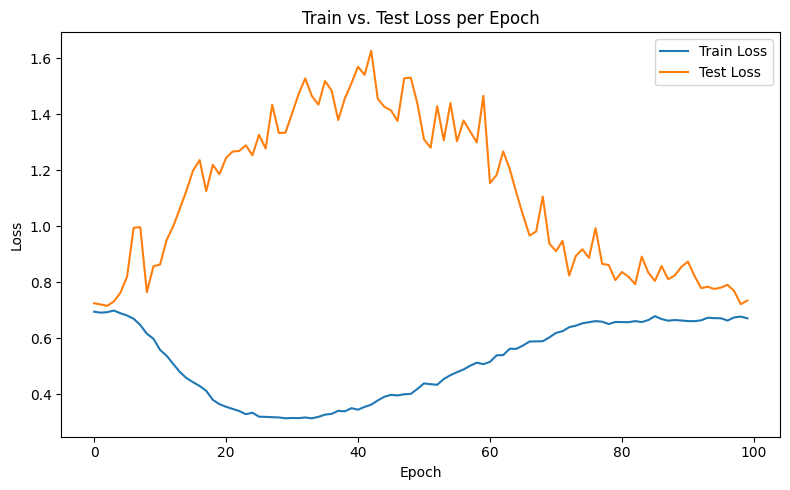

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.005 | Epochs: 100 | Batch: 64 | Security type: technical
[Epoch 5/100]  Train Loss: 0.6432
[Epoch 10/100]  Train Loss: 0.5231
[Epoch 15/100]  Train Loss: 0.4215
[Epoch 20/100]  Train Loss: 0.3462
[Epoch 25/100]  Train Loss: 0.3338
[Epoch 30/100]  Train Loss: 0.3612
[Epoch 35/100]  Train Loss: 0.3844
[Epoch 40/100]  Train Loss: 0.4045
[Epoch 45/100]  Train Loss: 0.4310
[Epoch 50/100]  Train Loss: 0.4663
[Epoch 55/100]  Train Loss: 0.5012
[Epoch 60/100]  Train Loss: 0.5405
[Epoch 65/100]  Train Loss: 0.5689
[Epoch 70/100]  Train Loss: 0.6112
[Epoch 75/100]  Train Loss: 0.6412
[Epoch 80/100]  Train Loss: 0.6670
[Epoch 85/100]  Train Loss: 0.6616
[Epoch 90/100]  Train Loss: 0.6783
[Epoch 95/100]  Train Loss: 0.6828
[Epoch 100/100]  Train Loss: 0.6837
Accuracy on Nonzero Predictions: 0.4533


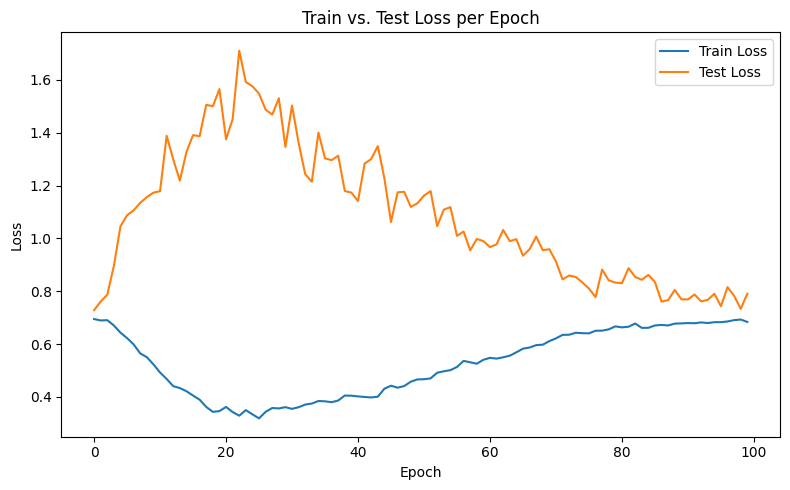

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
----- Appending stock: AAPL, period: 10y, data_type: technical -----
----- Appending stock: MSFT, period: 10y, data_type: technical -----
----- Appending stock: AMZN, period: 10y, data_type: technical -----
----- Appending stock: NVDA, period: 10y, data_type: technical -----
----- Appending stock: SPX, period: 10y, data_type: technical -----
Final X shape: (10890, 92, 100)
Final y shape: (10890,)
Training SPX | LR: 0.005 | Epochs: 100 | Batch: 64 | Security type: technical
[Epoch 5/100]  Train Loss: 0.2313
[Epoch 10/100]  Train Loss: 0.0405
[Epoch 15/100]  Train Loss: 0.0024
[Epoch 20/100]  Train Loss: 0.0005
[Epoch 25/100]  Train Loss: 0.0003
[Epoch 30/100]  Train Loss: 0.0001
[Epoch 35/100]  Train Loss: 0.0001
[Epoch 40/100]  Train Loss: 0.0000
[Epoch 45/100]  Train Loss: 0.0000
[Epoch 50/100]  Train Loss: 0.0000
[Epoch 55/100]  Train Loss: 0.0000
[Epoch 60/100]  Train Loss: 0.00

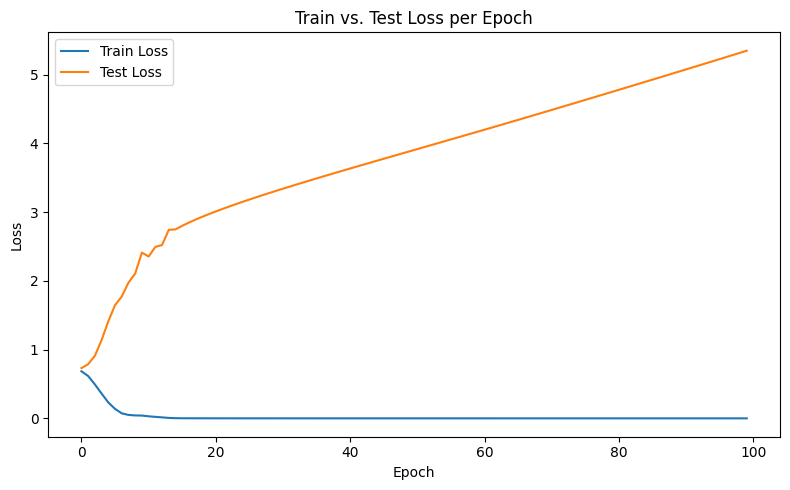

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.005 | Epochs: 100 | Batch: 64 | Security type: technical
[Epoch 5/100]  Train Loss: 0.2261
[Epoch 10/100]  Train Loss: 0.0190
[Epoch 15/100]  Train Loss: 0.0012
[Epoch 20/100]  Train Loss: 0.0005
[Epoch 25/100]  Train Loss: 0.0003
[Epoch 30/100]  Train Loss: 0.0001
[Epoch 35/100]  Train Loss: 0.0001
[Epoch 40/100]  Train Loss: 0.0000
[Epoch 45/100]  Train Loss: 0.0000
[Epoch 50/100]  Train Loss: 0.0000
[Epoch 55/100]  Train Loss: 0.0000
[Epoch 60/100]  Train Loss: 0.0000
[Epoch 65/100]  Train Loss: 0.0000
[Epoch 70/100]  Train Loss: 0.0000
[Epoch 75/100]  Train Loss: 0.0000
[Epoch 80/100]  Train Loss: 0.0000
[Epoch 85/100]  Train Loss: 0.0000
[Epoch 90/100]  Train Loss: 0.0000
[Epoch 95/100]  Train Loss: 0.0000
[Epoch 100/100]  Train Loss: 0.0000
Accuracy on Nonzero Predictions: 0.4767


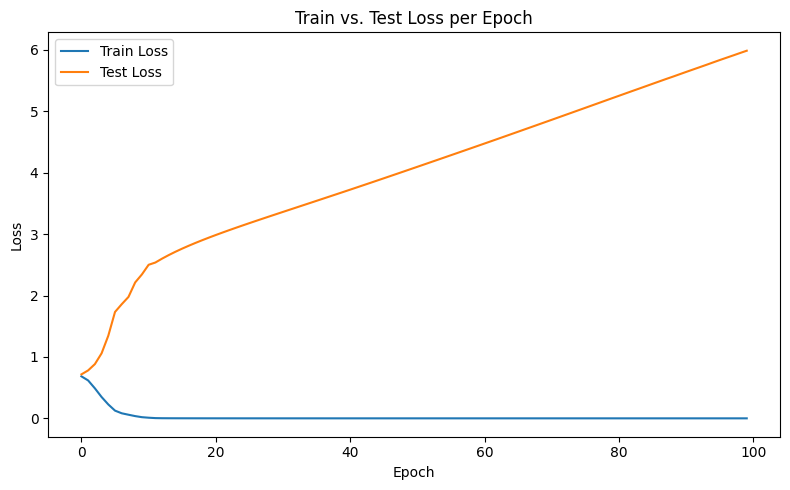

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.005 | Epochs: 100 | Batch: 64 | Security type: technical
[Epoch 5/100]  Train Loss: 0.2484
[Epoch 10/100]  Train Loss: 0.0212
[Epoch 15/100]  Train Loss: 0.0011
[Epoch 20/100]  Train Loss: 0.0004
[Epoch 25/100]  Train Loss: 0.0002
[Epoch 30/100]  Train Loss: 0.0001
[Epoch 35/100]  Train Loss: 0.0001
[Epoch 40/100]  Train Loss: 0.0000
[Epoch 45/100]  Train Loss: 0.0000
[Epoch 50/100]  Train Loss: 0.0000
[Epoch 55/100]  Train Loss: 0.0000
[Epoch 60/100]  Train Loss: 0.0000
[Epoch 65/100]  Train Loss: 0.0000
[Epoch 70/100]  Train Loss: 0.0000
[Epoch 75/100]  Train Loss: 0.0000
[Epoch 80/100]  Train Loss: 0.0000
[Epoch 85/100]  Train Loss: 0.0000
[Epoch 90/100]  Train Loss: 0.0000
[Epoch 95/100]  Train Loss: 0.0000
[Epoch 100/100]  Train Loss: 0.0000
Accuracy on Nonzero Predictions: 0.4367


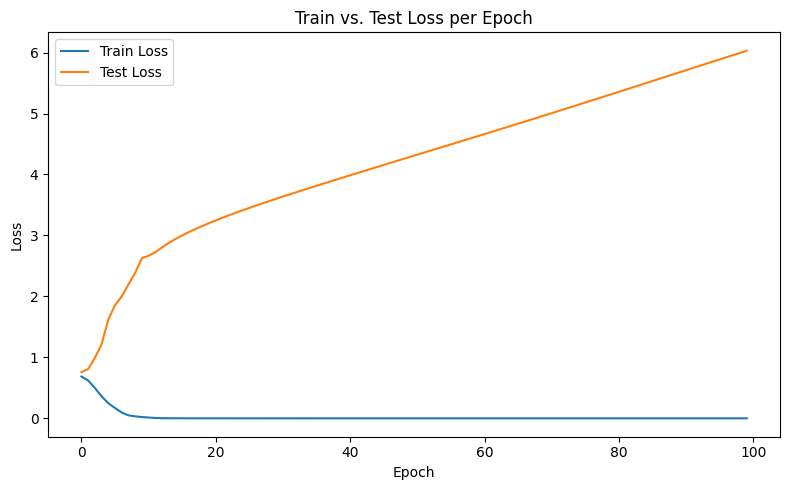

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.005 | Epochs: 100 | Batch: 64 | Security type: technical
[Epoch 5/100]  Train Loss: 0.2417
[Epoch 10/100]  Train Loss: 0.0135
[Epoch 15/100]  Train Loss: 0.0011
[Epoch 20/100]  Train Loss: 0.0004
[Epoch 25/100]  Train Loss: 0.0002
[Epoch 30/100]  Train Loss: 0.0001
[Epoch 35/100]  Train Loss: 0.0001
[Epoch 40/100]  Train Loss: 0.0000
[Epoch 45/100]  Train Loss: 0.0000
[Epoch 50/100]  Train Loss: 0.0000
[Epoch 55/100]  Train Loss: 0.0000
[Epoch 60/100]  Train Loss: 0.0000
[Epoch 65/100]  Train Loss: 0.0000
[Epoch 70/100]  Train Loss: 0.0000
[Epoch 75/100]  Train Loss: 0.0000
[Epoch 80/100]  Train Loss: 0.0000
[Epoch 85/100]  Train Loss: 0.0000
[Epoch 90/100]  Train Loss: 0.0000
[Epoch 95/100]  Train Loss: 0.0000
[Epoch 100/100]  Train Loss: 0.0000
Accuracy on Nonzero Predictions: 0.4500


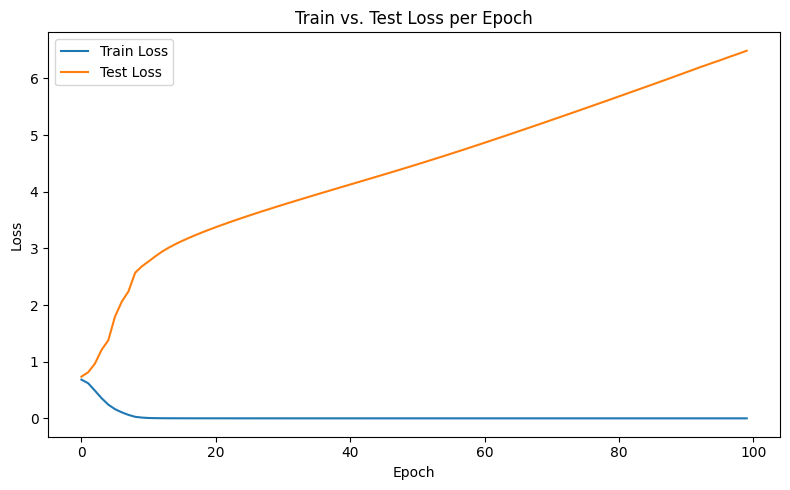

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.005 | Epochs: 100 | Batch: 64 | Security type: technical
[Epoch 5/100]  Train Loss: 0.2205
[Epoch 10/100]  Train Loss: 0.0140
[Epoch 15/100]  Train Loss: 0.0011
[Epoch 20/100]  Train Loss: 0.0004
[Epoch 25/100]  Train Loss: 0.0002
[Epoch 30/100]  Train Loss: 0.0001
[Epoch 35/100]  Train Loss: 0.0001
[Epoch 40/100]  Train Loss: 0.0000
[Epoch 45/100]  Train Loss: 0.0000
[Epoch 50/100]  Train Loss: 0.0000
[Epoch 55/100]  Train Loss: 0.0000
[Epoch 60/100]  Train Loss: 0.0000
[Epoch 65/100]  Train Loss: 0.0000
[Epoch 70/100]  Train Loss: 0.0000
[Epoch 75/100]  Train Loss: 0.0000
[Epoch 80/100]  Train Loss: 0.0000
[Epoch 85/100]  Train Loss: 0.0000
[Epoch 90/100]  Train Loss: 0.0000
[Epoch 95/100]  Train Loss: 0.0000
[Epoch 100/100]  Train Loss: 0.0000
Accuracy on Nonzero Predictions: 0.4767


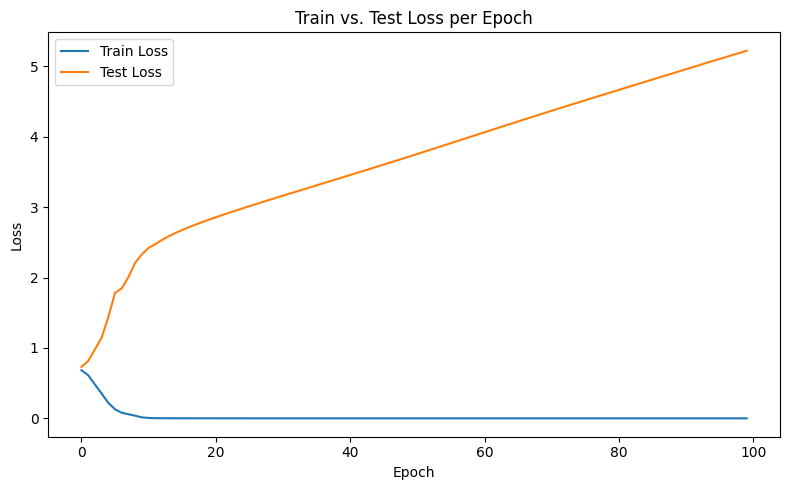

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.005 | Epochs: 100 | Batch: 64 | Security type: technical
[Epoch 5/100]  Train Loss: 0.5748
[Epoch 10/100]  Train Loss: 0.3373
[Epoch 15/100]  Train Loss: 0.2078
[Epoch 20/100]  Train Loss: 0.1625
[Epoch 25/100]  Train Loss: 0.1533
[Epoch 30/100]  Train Loss: 0.1397
[Epoch 35/100]  Train Loss: 0.1440
[Epoch 40/100]  Train Loss: 0.1561
[Epoch 45/100]  Train Loss: 0.1685
[Epoch 50/100]  Train Loss: 0.1799
[Epoch 55/100]  Train Loss: 0.2030
[Epoch 60/100]  Train Loss: 0.2483
[Epoch 65/100]  Train Loss: 0.3468
[Epoch 70/100]  Train Loss: 0.3634
[Epoch 75/100]  Train Loss: 0.4461
[Epoch 80/100]  Train Loss: 0.4877
[Epoch 85/100]  Train Loss: 0.5416
[Epoch 90/100]  Train Loss: 0.5715
[Epoch 95/100]  Train Loss: 0.6134
[Epoch 100/100]  Train Loss: 0.6186
Accuracy on Nonzero Predictions: 0.4433


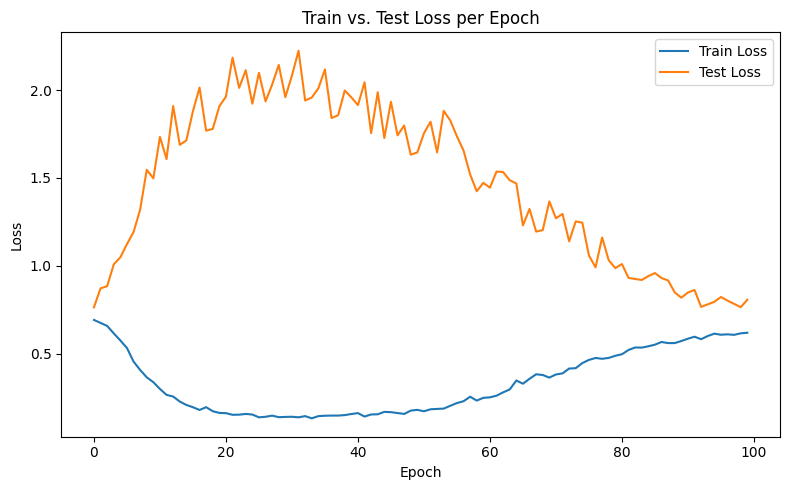

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.005 | Epochs: 100 | Batch: 64 | Security type: technical
[Epoch 5/100]  Train Loss: 0.5657
[Epoch 10/100]  Train Loss: 0.3236
[Epoch 15/100]  Train Loss: 0.2011
[Epoch 20/100]  Train Loss: 0.1704
[Epoch 25/100]  Train Loss: 0.1468
[Epoch 30/100]  Train Loss: 0.1510
[Epoch 35/100]  Train Loss: 0.1523
[Epoch 40/100]  Train Loss: 0.1519
[Epoch 45/100]  Train Loss: 0.1653
[Epoch 50/100]  Train Loss: 0.1958
[Epoch 55/100]  Train Loss: 0.2198
[Epoch 60/100]  Train Loss: 0.2496
[Epoch 65/100]  Train Loss: 0.2752
[Epoch 70/100]  Train Loss: 0.3463
[Epoch 75/100]  Train Loss: 0.3896
[Epoch 80/100]  Train Loss: 0.4838
[Epoch 85/100]  Train Loss: 0.5182
[Epoch 90/100]  Train Loss: 0.5495
[Epoch 95/100]  Train Loss: 0.5863
[Epoch 100/100]  Train Loss: 0.6012
Accuracy on Nonzero Predictions: 0.5067


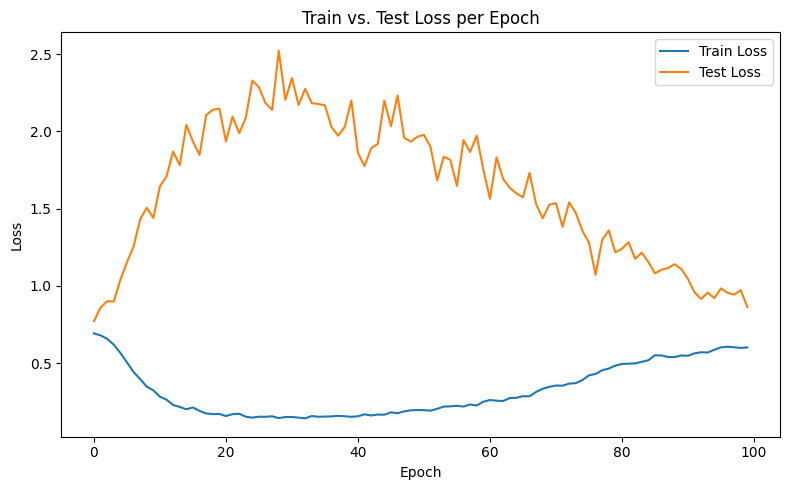

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.005 | Epochs: 100 | Batch: 64 | Security type: technical
[Epoch 5/100]  Train Loss: 0.5664
[Epoch 10/100]  Train Loss: 0.3204
[Epoch 15/100]  Train Loss: 0.2166
[Epoch 20/100]  Train Loss: 0.1708
[Epoch 25/100]  Train Loss: 0.1571
[Epoch 30/100]  Train Loss: 0.1576
[Epoch 35/100]  Train Loss: 0.1449
[Epoch 40/100]  Train Loss: 0.1671
[Epoch 45/100]  Train Loss: 0.1677
[Epoch 50/100]  Train Loss: 0.1780
[Epoch 55/100]  Train Loss: 0.2477
[Epoch 60/100]  Train Loss: 0.2941
[Epoch 65/100]  Train Loss: 0.3238
[Epoch 70/100]  Train Loss: 0.4280
[Epoch 75/100]  Train Loss: 0.5002
[Epoch 80/100]  Train Loss: 0.5600
[Epoch 85/100]  Train Loss: 0.6175
[Epoch 90/100]  Train Loss: 0.6246
[Epoch 95/100]  Train Loss: 0.6408
[Epoch 100/100]  Train Loss: 0.6532
Accuracy on Nonzero Predictions: 0.4800


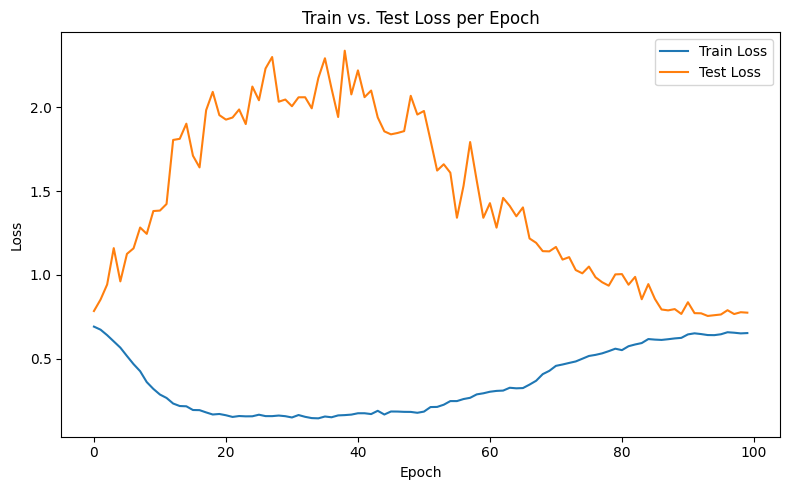

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.005 | Epochs: 100 | Batch: 64 | Security type: technical
[Epoch 5/100]  Train Loss: 0.5741
[Epoch 10/100]  Train Loss: 0.3317
[Epoch 15/100]  Train Loss: 0.2280
[Epoch 20/100]  Train Loss: 0.1823
[Epoch 25/100]  Train Loss: 0.1610
[Epoch 30/100]  Train Loss: 0.1645
[Epoch 35/100]  Train Loss: 0.1575
[Epoch 40/100]  Train Loss: 0.1817
[Epoch 45/100]  Train Loss: 0.1943
[Epoch 50/100]  Train Loss: 0.2490
[Epoch 55/100]  Train Loss: 0.3473
[Epoch 60/100]  Train Loss: 0.4166
[Epoch 65/100]  Train Loss: 0.4947
[Epoch 70/100]  Train Loss: 0.5183
[Epoch 75/100]  Train Loss: 0.5785
[Epoch 80/100]  Train Loss: 0.6244
[Epoch 85/100]  Train Loss: 0.6317
[Epoch 90/100]  Train Loss: 0.6429
[Epoch 95/100]  Train Loss: 0.6586
[Epoch 100/100]  Train Loss: 0.6805
Accuracy on Nonzero Predictions: 0.4200


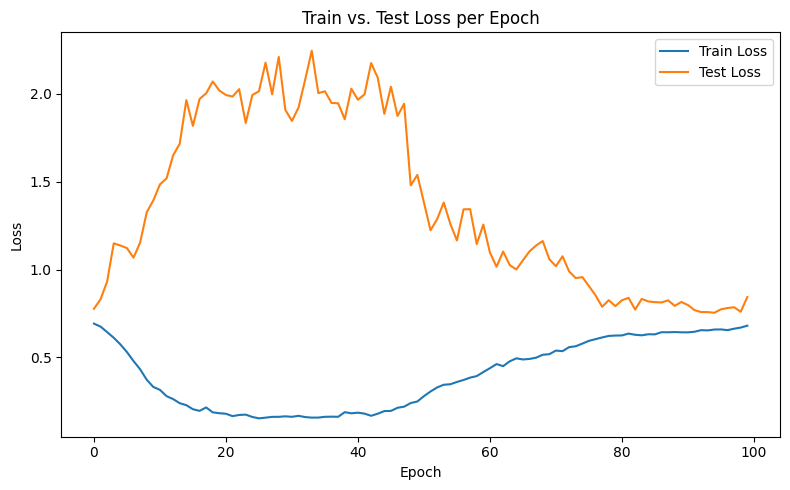

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.005 | Epochs: 100 | Batch: 64 | Security type: technical
[Epoch 5/100]  Train Loss: 0.5613
[Epoch 10/100]  Train Loss: 0.3471
[Epoch 15/100]  Train Loss: 0.2505
[Epoch 20/100]  Train Loss: 0.1987
[Epoch 25/100]  Train Loss: 0.1774
[Epoch 30/100]  Train Loss: 0.1673
[Epoch 35/100]  Train Loss: 0.1788
[Epoch 40/100]  Train Loss: 0.1795
[Epoch 45/100]  Train Loss: 0.2108
[Epoch 50/100]  Train Loss: 0.2370
[Epoch 55/100]  Train Loss: 0.2753
[Epoch 60/100]  Train Loss: 0.3520
[Epoch 65/100]  Train Loss: 0.4188
[Epoch 70/100]  Train Loss: 0.4716
[Epoch 75/100]  Train Loss: 0.5067
[Epoch 80/100]  Train Loss: 0.5339
[Epoch 85/100]  Train Loss: 0.5752
[Epoch 90/100]  Train Loss: 0.6048
[Epoch 95/100]  Train Loss: 0.6163
[Epoch 100/100]  Train Loss: 0.6195
Accuracy on Nonzero Predictions: 0.3600


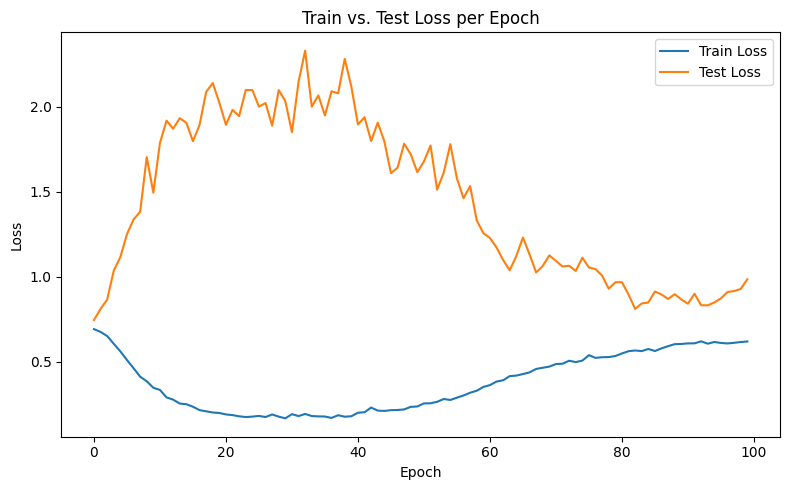

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png


In [12]:
model_types = ["lstm", "gru"]   
security_type = "technical"
sample_size = 5
window_sizes = [5, 10, 50, 100]
stocks = ['AAPL', 'MSFT', 'AMZN', 'NVDA', 'SPX']
test_size = 300

results_list = []

for window_size in window_sizes:
    X_combined, y_combined = combine_stocks_pkl_new_df(processing, security_type, period, window_size, project_dir, stocks, test_size)
    input_size = X_combined.shape[2]
    # train_size = int(X_combined.shape[0] * possible_train_size / 100)
    train_size = X_combined.shape[0] - test_size
    # test_size = X_combined.shape[0] - train_size

    for model_type in model_types:
        for i in range(sample_size):
            if model_type == "gru":
                model = GRU3DClassifier(input_size, hidden_size, output_size, num_layers, dropout)
            elif model_type == "lstm":
                model = StockPriceLSTM(input_size, hidden_size, output_size)

            model = model.to(device)

            optimizer = optim.Adam(model.parameters(), lr=learning_rate)
            print(f"Training {stocks[-1]} | LR: {learning_rate} | Epochs: {num_epochs} "
                  f"| Batch: {batch_size} | Security type: {security_type}")


            result = evaluate_model_plot(
                model, 
                X_combined, 
                y_combined, 
                criterion, 
                optimizer, 
                device, 
                train_size, 
                batch_size, 
                num_epochs, 
                lower_threshold = 0.5,
                plots_dir=plots_dir,
                plot_filename=None
            )

            # Store results in a list
            results_list.append({
                "security_type": security_type,
                "window_size": window_size,
                "model_type": model_type,
                "iteration": i + 1,
                "accuracy_nonzero": result["accuracy_nonzero"],
                "loss_decrease_percentage": result["loss_decrease_percentage"],
                "final_train_loss": result["final_train_loss"]
            })

results_df = pd.DataFrame(results_list)

In [13]:
results_df

,security_type,window_size,model_type,iteration,accuracy_nonzero,loss_decrease_percentage,final_train_loss
0,technical,5,lstm,1,0.513333,-71.473881,1.976269e-01
1,technical,5,lstm,2,0.513333,-71.811542,1.952888e-01
2,technical,5,lstm,3,0.533333,-68.279069,2.197945e-01
3,technical,5,lstm,4,0.536667,-71.336565,1.986728e-01
4,technical,5,lstm,5,0.446667,-69.205277,2.134015e-01
5,technical,5,gru,1,0.536667,-1.340633,6.839403e-01
6,technical,5,gru,2,0.520000,0.646273,6.980632e-01
7,technical,5,gru,3,0.523333,-4.101720,6.652606e-01
8,technical,5,gru,4,0.470000,-0.179640,6.924169e-01
9,technical,5,gru,5,0.486667,-7.497637,6.413872e-01


In [14]:
output_folder = os.path.join(results_dir, 'combined_vs_individual_v1')
results_df.to_csv(os.path.join(output_folder, f'combined_technical.csv'), index=False)